# Technical demand response potential meta analysis - result comparison (overview)

**Puporse and background**: This notebook serves for evaluating the demand response potentials from different publications assessing technical demand response potentials for Germany. The data from the publications has been collected in order to carry out a meta analysis.

## Method applied
In the following, a brief description of the method applied is given for the sake of replicability.

### Selection of publications
Criterions for the selection of publications were:
* Regional focus: Federal republic of Germany
* Temporal restricitions: Publications until 2005
* Contents: technical demand response potentials
* Sectoral coverage: At least one of households, trade, commerce and services or industry assessed; no publications focusing on single appliances
* Own analysis carried out (no other meta analysis included)
* Inclusion of at least one of the parameters of interest (usually at least some information on potential in MW)

### Parameters assessed
Data for the following parameters was taken from the publications selected:
* eligibility: general eligibility of processes, applications or branches (demand response categories in the following) for load shifting, load shedding resp. (sole) load increase
* capacity-related parameters: capacity available for load shifting or load shedding, average, minimum and maximum load level, installed capacity as well as shiftable share of installed capacity
* time-reletad parameters: activation duration, interference duration, shifting duration, regenaration duration, maximum activations per year
* cost-related parameters: specific investments, variable costs (for activation), fixed costs

### Filtering and data collection
* A total of 70 publications has been selected in the first place in a literature research based on the titles, keywords and abstracts using terms like "Demand Response", "Demand Side Management", "Demand Side Integration", "load management", "load shifting", "load shedding", "potential", "Germany" as well as their German equivalents to formulate search strings. 
* Of these publications, 30 have met the above stated criteria and were further evaluated. 
* Because sometimes, several publications belonged to the same research project, these were grouped together resulting in 24 publication groups for which potential information has been evaluated.
* The data has been collected in an Excel Workbook ("Potenziale_Lastmanagement.xlsx"). The latest version of this Excel Workbook is evaluated with this notebook.

# Package imports
User-defined (workflow) functions are imported in order to prevent redundancies:
* *run_analyses_for_parameter_single_year*: Runs the entire analysis chain for one year (e.g. status quo, 2020 or 2030). This comprises:
    * extracting the parameter information of interest
    * adding counts for the number of publications and data points
    * grouping by process categories
    * transposing the data set and splitting it into the actual numeric data, the counts information and the sources information
    * extracting sample statistics, such as median and other quantiles
    * extracting and tidying up sample sources as well as
    * visualizing data in a boxplot resp. a combined boxplot and bee swarm plot
* *extract_data_for_parameter_all_years*: Extracts the data for a certain parameter for all years defined and saves the statistics and sources to .csv files. Includes al analyses steps but plotting.
* *extract_projection_for_all_years*: filters for certain process categories and combines the projection data into a single data set in order to visualize it. Includes all analyses steps but extracting statistics which has already been done in the course of the analyses.
* *extract_nlargest*: Determines the processes with the largest positive shifting potential.
* *extract_sample_sources*: extracts the sources information for a dedicated parameter and combines it into a unique string (that is written to a .txt file)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd

from collections import defaultdict
from drpotentials.evaluation_workflow import (
    run_analyses_for_parameter_single_year,
    extract_data_for_parameter_all_years,
    extract_projection_for_all_years,
    extract_nlargest
)
from drpotentials.evaluation_funcs import extract_sample_sources

# Allow for chained assignments (see note above)
pd.options.mode.chained_assignment = None

# Parameter settings
* Determine path folders and filenames.
* Create boolean flags to
    * determine whether or not to use the processes with the largest potentials for the potential outlook and
    * detect whether remaining has already been taken care of.

In [2]:
# Set paths and filenames for inputs
path_folder_in = "./inputs/"
path_folder_out = "./out/"
filename = "Potenziale_Lastmanagement.xlsx"
filename_colnames = "Columns.xlsx"

# Boolean flags
use_nlargest_cols = False
is_renamed = False

Configure the fontsizes for matplotlib objects

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Read in data
* Check the worksheets to be evaluated (may be skipped)
* Read in the Excel Workbook containing all data ("Potenziale_Lastmanagement.xlsx")
* Create a separate DataFrame with the potential information for every publication
* Parse mapping of processes to process categories (grouping)as well as mapping of colors to process categories for plots

In [4]:
# Get all sheet names
xls = xlrd.open_workbook(path_folder_in+filename, on_demand=True)
table_names = xls.sheet_names()

# Remove all sheets that do not contain potential information
removed_names = {el for el in table_names if len(el) > 6}

# Two publications were excluded in the latter process
removed_names.add("Stoe12")
removed_names.add("Bel15")
table_names = [
    el for el in table_names if el not in removed_names
]
# print(table_names)

In [5]:
xls = pd.ExcelFile(path_folder_in+filename)

# Publications
ape12 = xls.parse("Ape12")
ary17 = xls.parse("Ary17")
blu13 = xls.parse("Blu13")
foc11 = xls.parse("Foc11")
gil15 = xls.parse("Gil15")
gob12 = xls.parse("Gob12")
gro13 = xls.parse("Gro13")
gru17 = xls.parse("Gru17")
haa17 = xls.parse("Haa17")
hen15 = xls.parse("Hen15")
klo09 = xls.parse("Klo09")
klo13 = xls.parse("Klo13")
krz13 = xls.parse("Krz13")
lad18 = xls.parse("Lad18")
lan15 = xls.parse("Lan15")
lie15 = xls.parse("Lie15")
mol10 = xls.parse("Mol10")
pau11 = xls.parse("Pau11")
pel16 = xls.parse("Pel16")
r2b14 = xls.parse("r2b14")
roo10 = xls.parse("Roo10")
sta06 = xls.parse("Sta06")
ste17 = xls.parse("Ste17")
sty15 = xls.parse("Sty15")

# Categories and colors
categories = xls.parse("Kategorien_neu")
colors = xls.parse("Farben", index_col=0, header=0)

# Prepare data for further analysis
In the following, some data preparation steps are carried out in order to harmonize the data basis and ensure further usability.

## Shortcuts
Introduce shortcut to facilitate the analyses:
* dict holding all publications
* dict for the years for which potential information is available: define groups for years
* dict for filtering for sectors: Map the German sector names for industry (ind), trade commerce and services (tcs) and households (hoho) to their abbreviation

The following groups are defined for years:
* Status quo: prior to 2020
* 2020
* 2025 (including 2023)
* 2030
* 2035
* 2040
* 2045
* 2050

In [6]:
publications_dict = {
    "Ape12": ape12,
    "Ary17": ary17,
    "Blu13": blu13,
    "Foc11": foc11,
    "Gil15": gil15,
    "Gob12": gob12,
    "Gro13": gro13,
    "Gru17": gru17,
    "Haa17": haa17,
    "Hen15": hen15,
    "Klo09": klo09,
    "Klo13": klo13,
    "Krz13": krz13,
    "Lad18": lad18,
    "Lan15": lan15,
    "Lie15": lie15,
    "Mol10": mol10,
    "Pau11": pau11,
    "Pel16": pel16,
    "r2b14": r2b14,
    "Roo10": roo10,
    "Sta06": sta06,
    "Ste17": ste17,
    "Sty15": sty15
}

In [7]:
# Get the years for which potentials are given
set_years = set()

for k, v in publications_dict.items():
    for el in v["Jahr"].unique():
        set_years.add(el)

# Define two groups of years (for potential evaluation)
status_quo_years = {el for el in set_years if el < 2020}
years_2025 = {2023, 2025}

# Define year dict for checking the year (group)
years_dict = {
    "SQ": status_quo_years,
    "2020": [2020],
    "2025": years_2025,
    "2030": [2030],
    "2035": [2035],
    "2040": [2040],
    "2045": [2045],
    "2050": [2050]
}

In [8]:
# Define sector filter
filter_sector = {
    "ind": "Industrie",
    "tcs": "GHD",
    "hoho": "Haushalte"
}

## Prepare column names
Column names have to be carefully selected and harmonized in order to be able to compare potential information on a common basis. This holds especially for evaluating capacity-related parameters.

* Use predefined mapping of all parameter names in the original data basis.
* Map the parameters to groups with the information on the respective parameter.

In [9]:
# initialize an empty throwaway array
help_array = np.empty(shape=(0,))

# add all column values and convert to a set to remove duplicates
for k, v in publications_dict.items():
    help_array = np.concatenate((help_array, v.columns.values), axis = 0)
    
all_cols = set(help_array)

Prepare columns for further usage:

_Note: This is the only place where a manual adjustment is necessary, once the primary data basis is changed and further columns, not yet contained in it, are inserted._
* The list of all columns used has been transferred to an Excel workbook ("Columns.xlsx") using the following commented lines of code.
* The columns have been matched to one parameter for evaluation by going through them and assigning a parameter (has been done manually using Excel).
* The manipulated Excel workbook ("Columns.xlsx") is read in in the following again to be able to use the grouping applied.

In [10]:
# Uncomment this cell and reassign groups if changes to the columns in the data collection occur.
#all_cols_Series = pd.Series(data=sorted(list(all_cols)))
#all_cols_Series.to_excel(path_folder_in+filename_colnames, encoding="utf-8-sig", header=False)

In [11]:
all_cols_df = pd.read_excel(path_folder_in+filename_colnames, index_col=0)

groups = all_cols_df["Gruppe"].unique()

cols_dict = {}

for key in groups:
    cols_dict[key] = list(
        all_cols_df[all_cols_df["Gruppe"] == key].index.values
    )

swapped_cols_dict = {val: k for k, v in cols_dict.items() for val in v}

## Create an overall parameter data set with all information
Combine all DataFrames created from the Excel sheets of the dfferent studies into a single one holding all the information:
* Filter cols that don't need renaming (columns used for filtering etc.)
* Rename the other columns: Append the string for the study to the name of the parameter column in oder not to loose information in the latter aggregation
* Loop over the publications dict and concat the individual DataFrames in order to form one overall DataFrame that is used to flter the needed information in the following
* Add the study string to all columns containing sources infomation (i.e. all containing the German string 'Fundstelle')
* Merge the overall parameters data set with the process categories used for grouping

In [12]:
cols_not_to_rename = [
    "Prozess", "Sektorenzuordnung", "Jahr", 
    "Lastverschiebung", "Lastverzicht", "Lasterhöhung", 
    "study"
]
cols_not_to_rename.extend([
    col for col in all_cols if "Fundstelle" in col
])

In [13]:
parameters = pd.DataFrame()
if not is_renamed:
    for k, v in publications_dict.items():
        v["study"] = k

        cols_to_rename = {
            col: col + "_" + k for col in v.columns 
            if col not in cols_not_to_rename
        }
        for col, renamed_col in cols_to_rename.items():
            swapped_cols_dict[renamed_col] = swapped_cols_dict[col] 

        v.rename(columns=cols_to_rename, inplace=True)

        parameters = pd.concat([parameters, v])

    for el in parameters.columns:
        if "Fundstelle" in el:
            parameters[el] = (
                parameters["study"].values 
                + ": " 
                + parameters[el].astype(str).values
            )
    
    is_renamed = True

In [14]:
parameters = pd.merge(
    parameters, categories,
    left_on="Prozess", 
    right_on="Prozess (ursprüngliche Kategorien)",
    how="left"
)

## Aggregate data by process categories
Determine aggregation rules:
* For original columns, aggregation rules are given in the "Columns.xlsx" mapping specified. Columns not to be used are assigned a value of "drop" and neglected.
* For the modified columns including the study shorthand symbol, an assignment is made based on the predefined mapping, whereby all sources columns - those with the string "Fundstelle" in it - are assigned the sum as aggregation rule.
* In order not to create a lot of 0 entries by aggregating NaN values (which is the default behaviour), aggregation rule sum is replaced by a lambda function requiring a `min_count` of 1, i.e. at least of entry being notnull.

In [15]:
agg_dict = all_cols_df["Aggregationsregel"].loc[
    all_cols_df["Aggregationsregel"] != "drop"
].to_dict()
agg_dict["study"] = "first"

new_agg_dict = {}
for col in parameters.columns:
    for k, v in agg_dict.items():
        if k in col:
            if not "Fundstelle" in col:
                new_agg_dict[col] = v
            else:
                new_agg_dict[col] = lambda x: x.sum(min_count=1)

In [16]:
reversed_agg_dict = defaultdict(list)
for k, v in new_agg_dict.items():
    reversed_agg_dict[v].append(k)
    
for k in reversed_agg_dict["sum"]:
    new_agg_dict[k] = lambda x: x.sum(min_count=1)

Group by process category within studies in order to remove duplicates:
* Use the above defined filters for studis, sectors and years.
* Iterate over studies, sectors and years;<br>
_Note: Due to the nested for-loops, this operation is quite expensive, but only needed once here._
* Filter DataFrame accordingly and groupby "Prozesskategorie" to remove duplicates

In [17]:
grouped = pd.DataFrame()
for study in publications_dict.keys():
    for sector, sector_filter in filter_sector.items():
        for year_key, year_value in years_dict.items():
            
            filtered = parameters.loc[
                (parameters["study"] == study)
                & (parameters["Sektorenzuordnung"] == sector_filter)
                & (parameters["Jahr"].isin(year_value))
            ].dropna(axis=1, how="all")
            
            if not filtered.empty:
            
                filtered = filtered.groupby("Prozesskategorie").agg({
                    k: v for k, v in new_agg_dict.items() if k in filtered.columns
                })
                grouped = pd.concat([grouped, filtered])

# Eligibility for load shifting / load shedding
* Extract eligibility for the status quo (cross-sectoral consideration)
* Groupby process categories
* Calculate the numbers for non-eligibility by calculating the differences between the overall amount and the numbers for eligibility
* Write to csv and plot in a stacked bar plot
* Extract sources information

In [18]:
# Extrat info on eligibility and number off publications
grouped_SQ = grouped.loc[grouped["Jahr"].isin(status_quo_years)]
eligibility = grouped_SQ[
    ["Lastverschiebung", "Lastverzicht", "Lasterhöhung"]
].groupby(grouped_SQ.index).sum()
eligibility["Anzahl"] = grouped_SQ.index.value_counts()

# Calculate info on non-eligibility
eligibility["Lastverschiebung ungeeignet"] = (
    eligibility["Anzahl"].values - eligibility["Lastverschiebung"].values 
)
eligibility["Lastverzicht ungeeignet"] = (
    eligibility["Anzahl"].values - eligibility["Lastverzicht"].values 
)
eligibility["Lasterhöhung ungeeignet"] = (
    eligibility["Anzahl"].values - eligibility["Lasterhöhung"].values 
)
eligibility.sort_values(by="Anzahl", ascending=False, inplace=True)
eligibility.index.name = "Lastmanagementkategorie"

In [19]:
# Write eligibility stats (used as input for clustering routine)
eligibility.to_csv(path_folder_in+"eligibility_stats.csv")

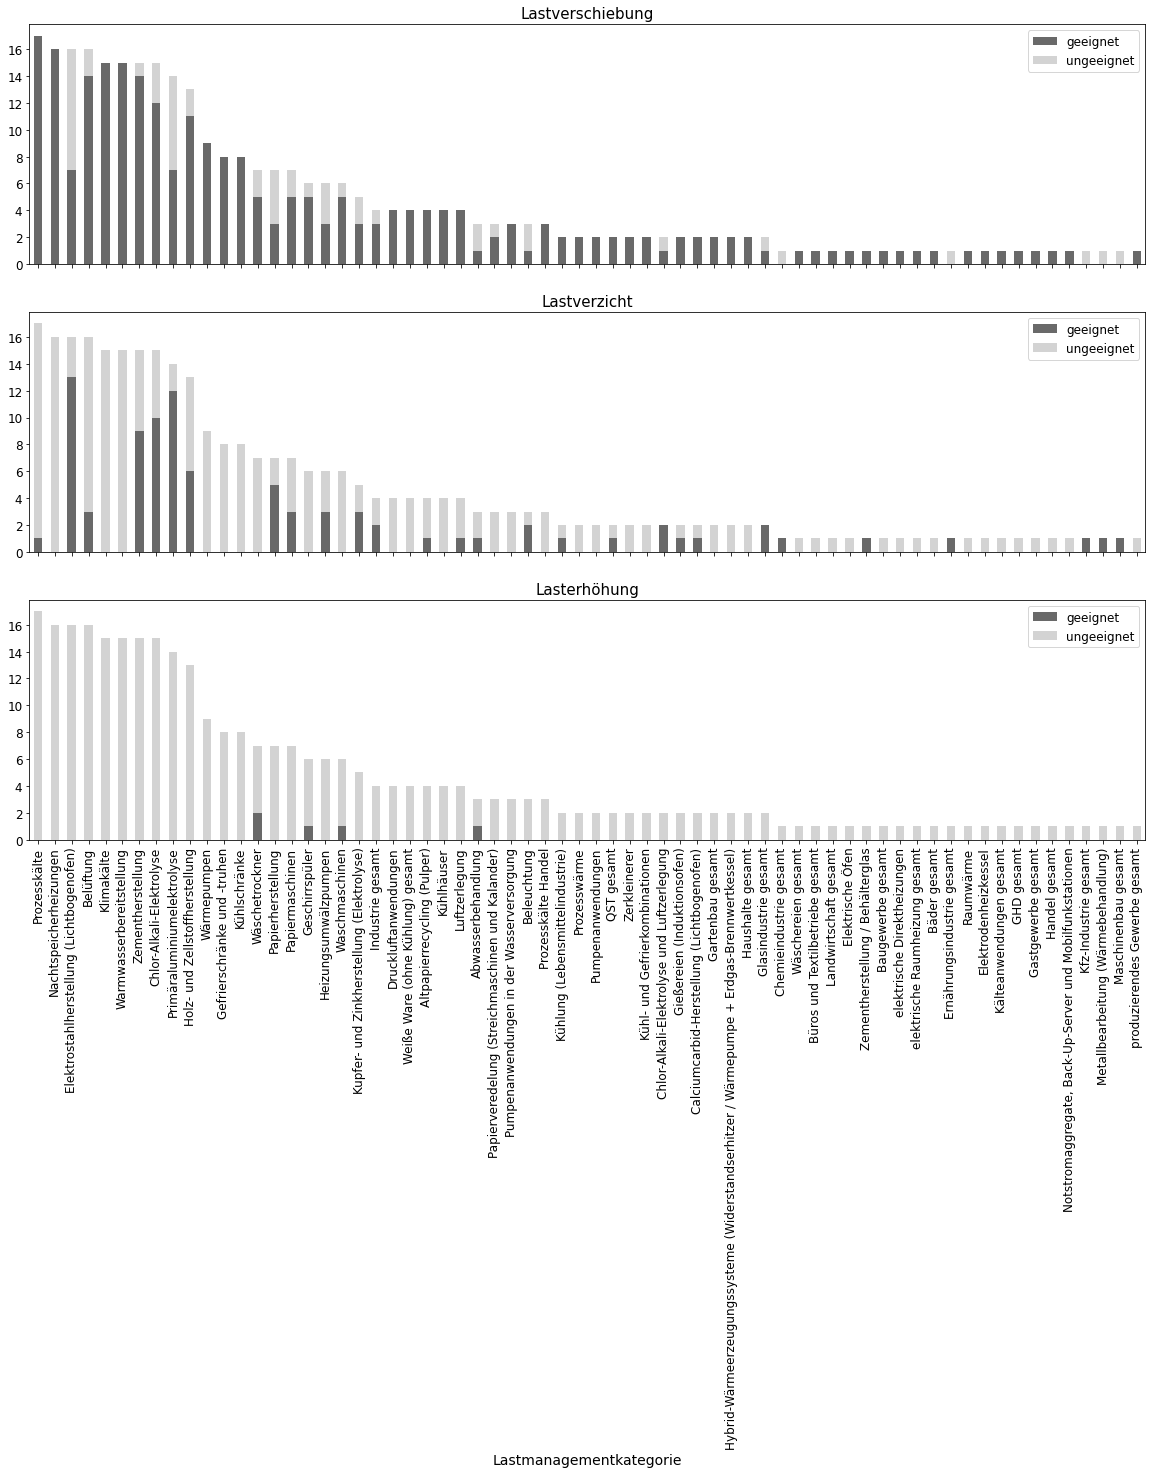

In [20]:
# Plot eligibiliy / non-eligibility information
fig, ax = plt.subplots(3, 1, figsize=(20,15), sharex = True)

for i, el in enumerate(["Lastverschiebung", "Lastverzicht", "Lasterhöhung"]):

    _ = eligibility[[el, el + " ungeeignet"]].rename(columns={
            el: "geeignet",
            el + " ungeeignet": "ungeeignet"
        }).plot(
            kind="bar", 
            stacked=True,
            color=["dimgrey", "lightgrey"],
            ax=ax[i]
    )
    _ = ax[i].set_title(el)

plt.savefig("./out/plots/eligibility_all.png", dpi = 150, bbox_inches = "tight")

plt.show()    

In [21]:
# Extract sources infomation
sources_eligibility_df = grouped_SQ[[
    "Fundstelle Lastverzicht",
    "Fundstelle Lastverschiebung",
    "Fundstelle Lasterhöhung"
]].groupby(grouped_SQ.index).agg(lambda x: "; ".join(x))

eligibility_sources = extract_sample_sources(
    sources_eligibility_df, 
    save=True, 
    path_folder="./out/sources/", 
    file_name="sources_eligibility.txt"
)

# Capacity-related parameters
In the following, all capacity-related demand response parameters are evaluated. These comprise
* demand response potentials in positive or negative direction (in MW),
* average, minimum and maximum load factors (in percent of installed capacity) as well as
* installed capacities (in MW) and shiftable load share (in percent).

The evaluation is carried out per process / appliance / branch (demand response category) for a given sector and year.

## Industry

### Positive load shift potential

In [22]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_ind_stats",
    file_name_sources="potential_pos_ave_ind_sources",
    filter_sector=filter_sector
)

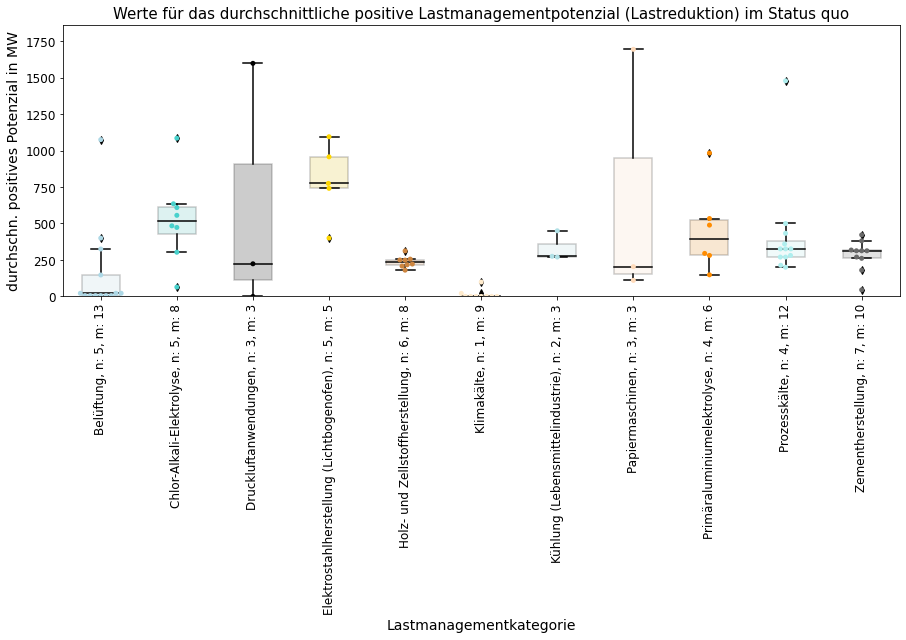

In [23]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das durchschnittliche positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [24]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_ind_stats",
    file_name_sources="potential_pos_min_ind_sources",
    filter_sector=filter_sector
)

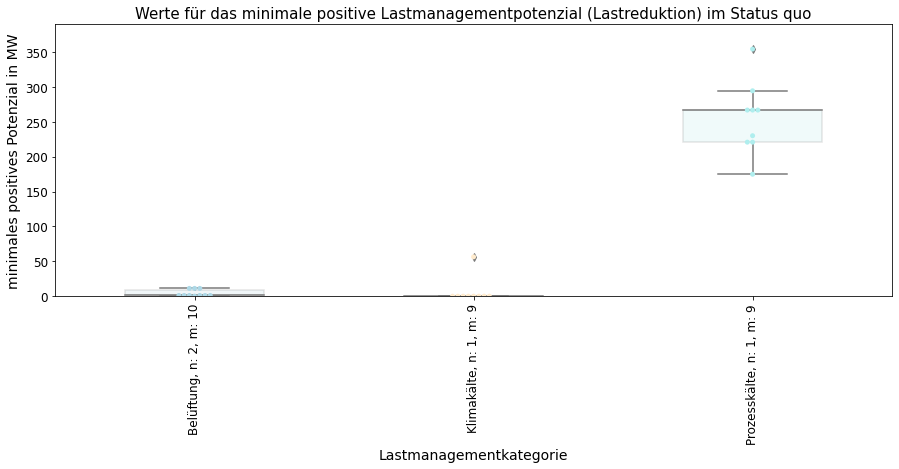

In [25]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [26]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_ind_stats",
    file_name_sources="potential_pos_max_ind_sources",
    filter_sector=filter_sector
)

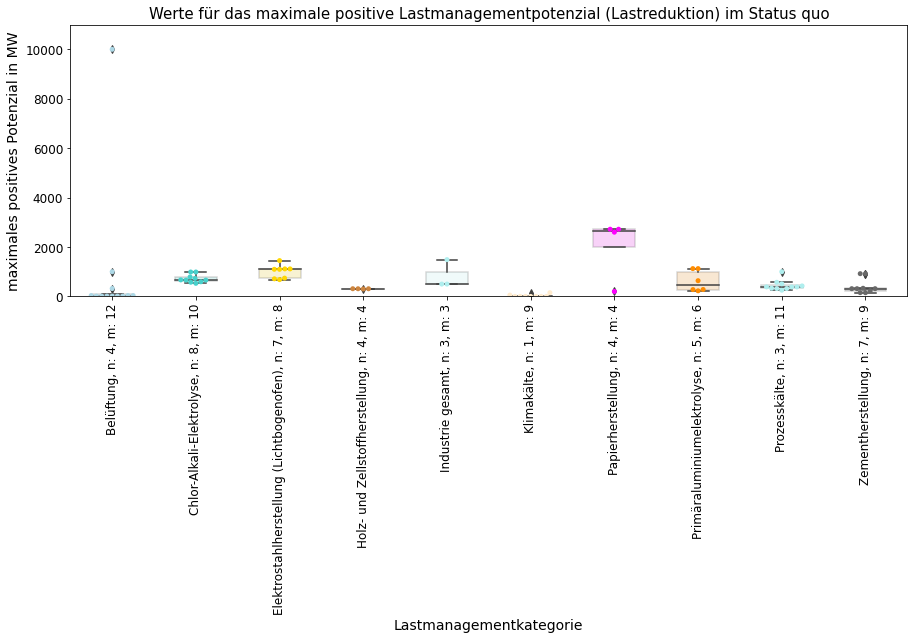

In [27]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [28]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_ind_stats",
    file_name_sources="potential_pos_overall_ind_sources",
    filter_sector=filter_sector
)

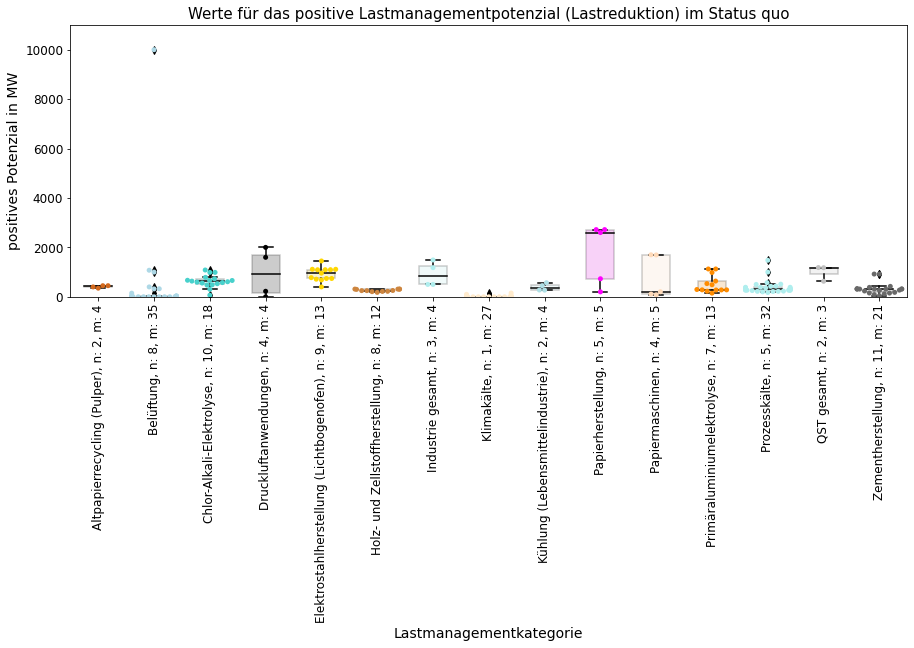

In [29]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Positive load shedding potential

In [30]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_shed_ind_stats",
    file_name_sources="potential_pos_ave_shed_ind_sources",
    filter_sector=filter_sector
)

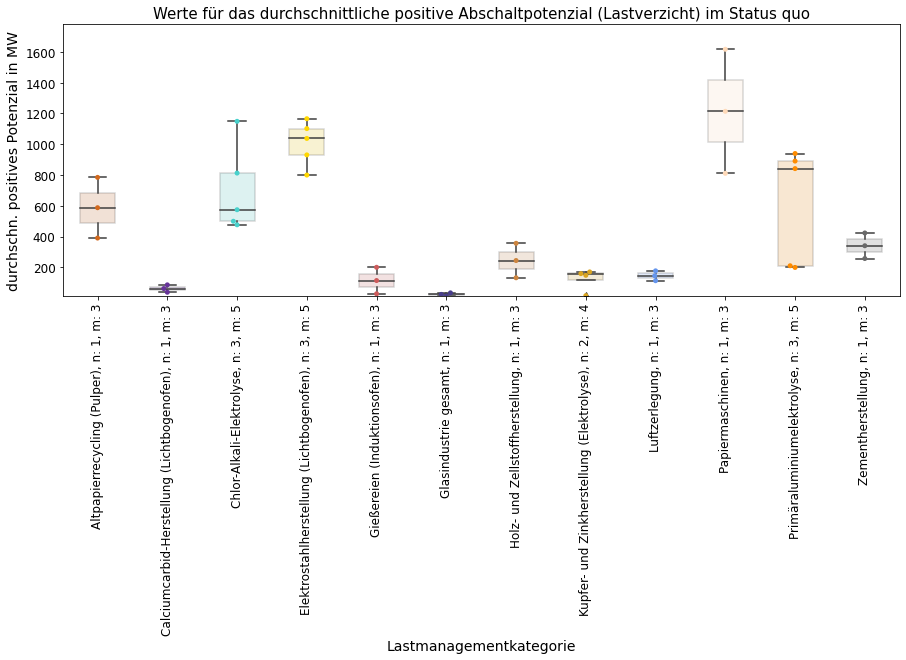

In [31]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche positive "
        "Abschaltpotenzial (Lastverzicht)"
    ),
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [32]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_shed_ind_stats",
    file_name_sources="potential_pos_min_shed_ind_sources",
    filter_sector=filter_sector
)

In [33]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


In [34]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_shed_ind_stats",
    file_name_sources="potential_pos_max_shed_ind_sources",
    filter_sector=filter_sector
)

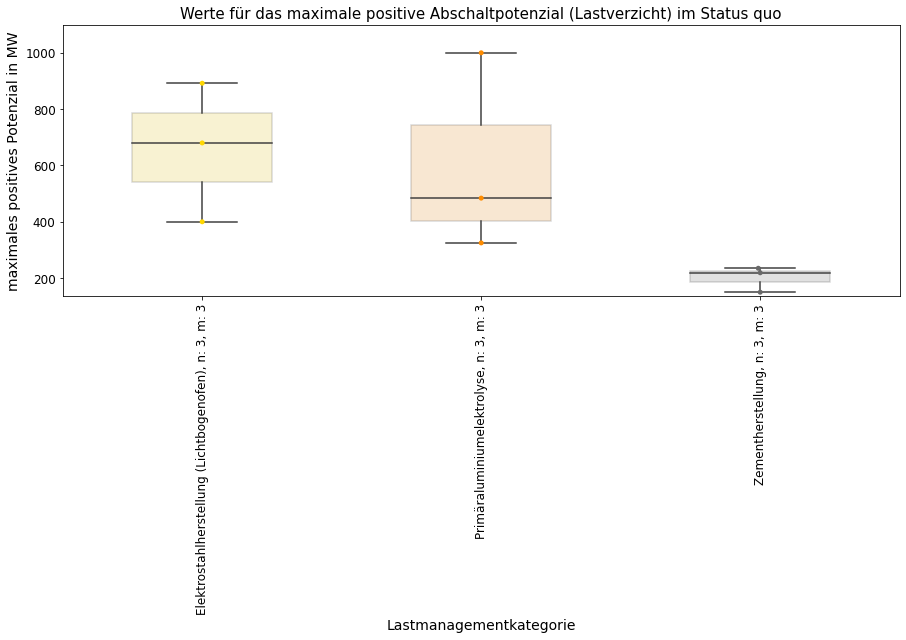

In [35]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [36]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht", 
        "Potenzial positiv min Lastverzicht", 
        "Potenzial positiv max Lastverzicht"
    ],
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_shed_ind_stats",
    file_name_sources="potential_pos_overall_shed_ind_sources",
    filter_sector=filter_sector
)

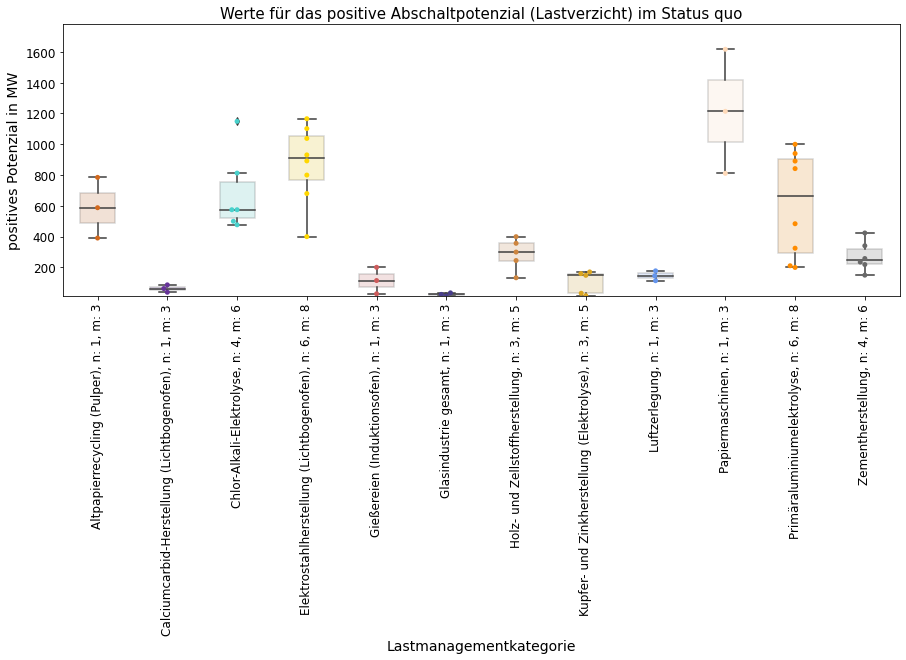

In [37]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht",
        "Potenzial positiv min Lastverzicht",
        "Potenzial positiv max Lastverzicht"],
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Negative load shift potential

In [38]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_neg_ave_ind_stats",
    file_name_sources="potential_neg_ave_ind_sources",
    filter_sector=filter_sector
)

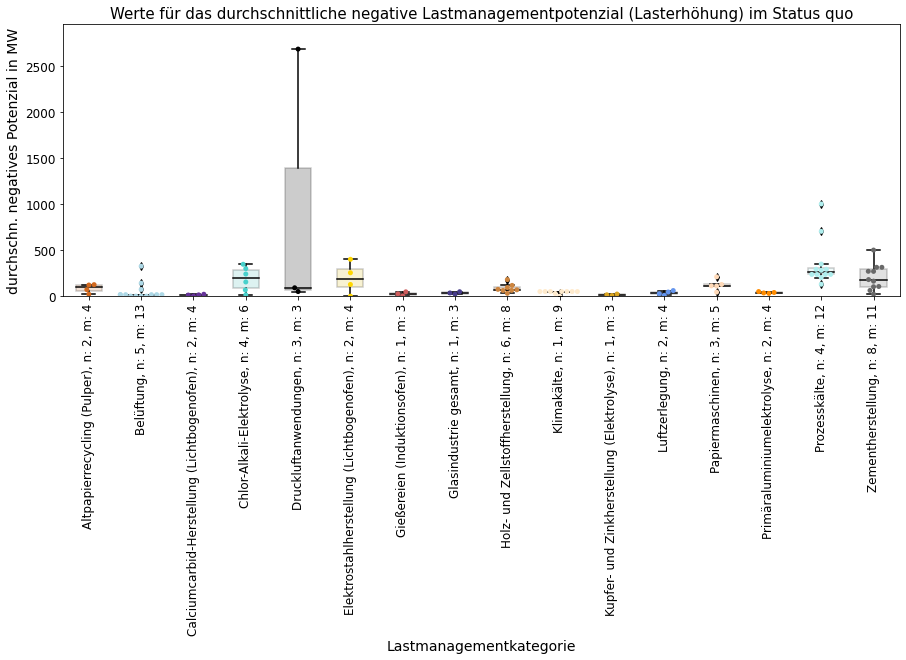

In [39]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche negative "
        "Lastmanagementpotenzial (Lasterhöhung)"
    ),
    plot_ylabel="durchschn. negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [40]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_neg_min_ind_stats",
    file_name_sources="potential_neg_min_ind_sources",
    filter_sector=filter_sector
)

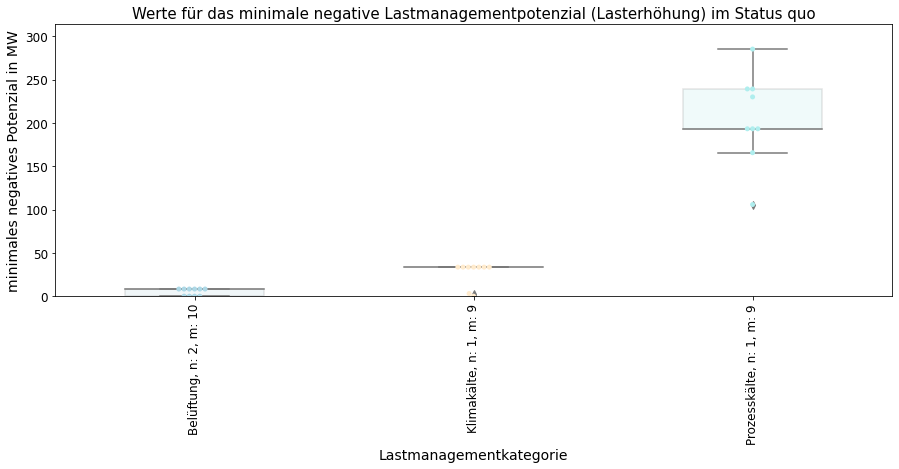

In [41]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="minimales negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [42]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_neg_max_ind_stats",
    file_name_sources="potential_neg_max_ind_sources",
    filter_sector=filter_sector
)

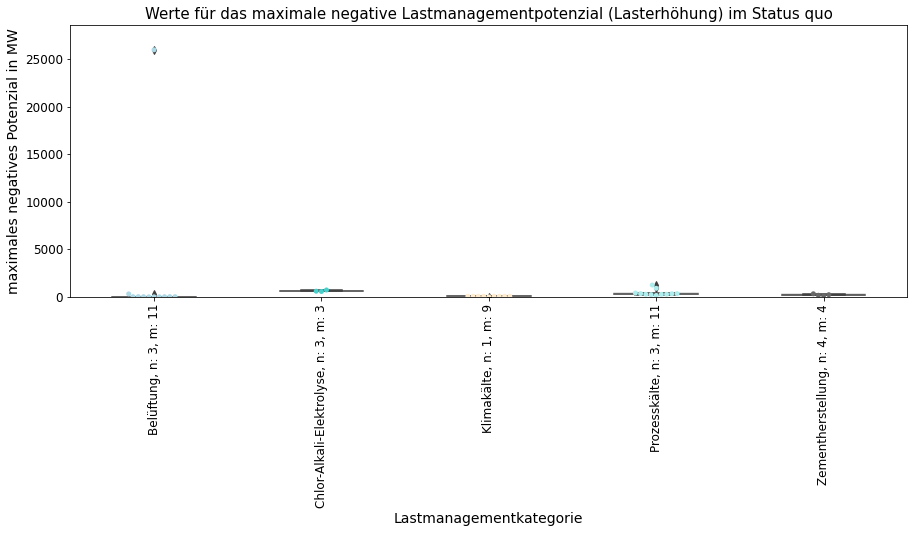

In [43]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="maximales negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [44]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_neg_overall_ind_stats",
    file_name_sources="potential_neg_overall_ind_sources",
    filter_sector=filter_sector
)

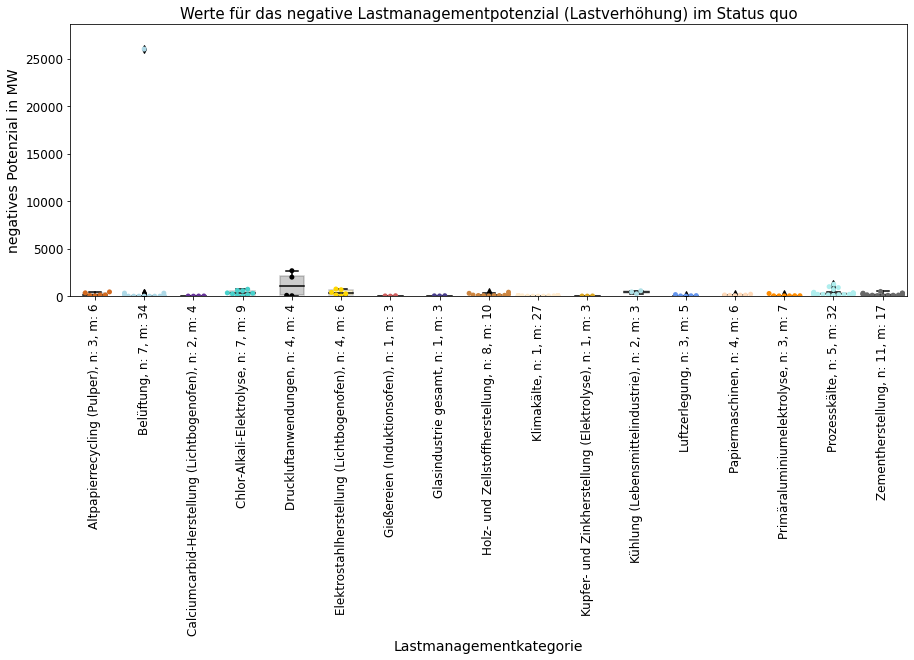

In [45]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das negative Lastmanagementpotenzial (Lastverhöhung)",
    plot_ylabel="negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Average load values

In [46]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="ave_load_ind_stats",
    file_name_sources="ave_load_ind_sources",
    filter_sector=filter_sector
)

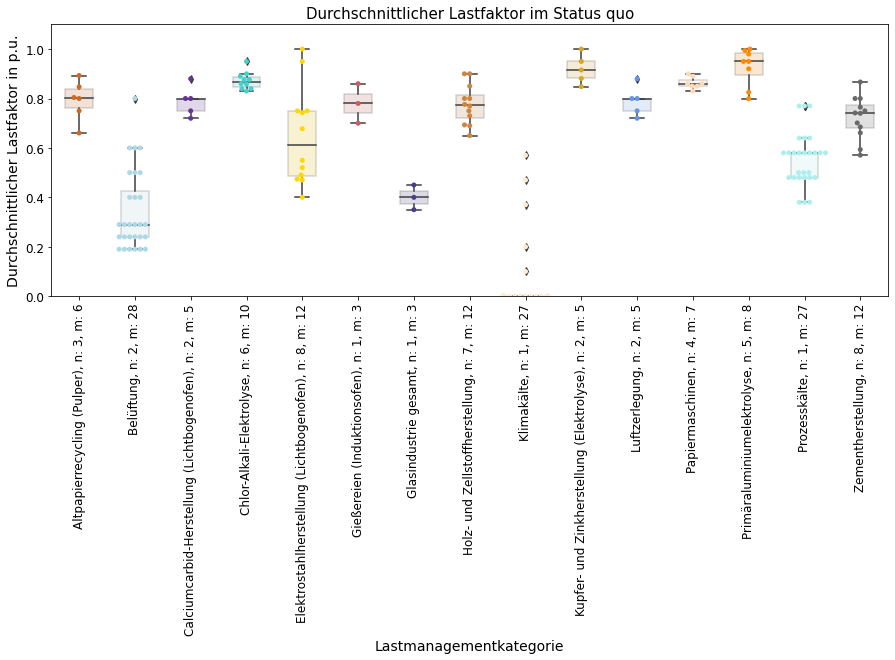

In [47]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Durchschnittlicher Lastfaktor",
    plot_ylabel="Durchschnittlicher Lastfaktor in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Minimum load values

In [48]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="min_load_ind_stats",
    file_name_sources="min_load_ind_sources",
    filter_sector=filter_sector
)

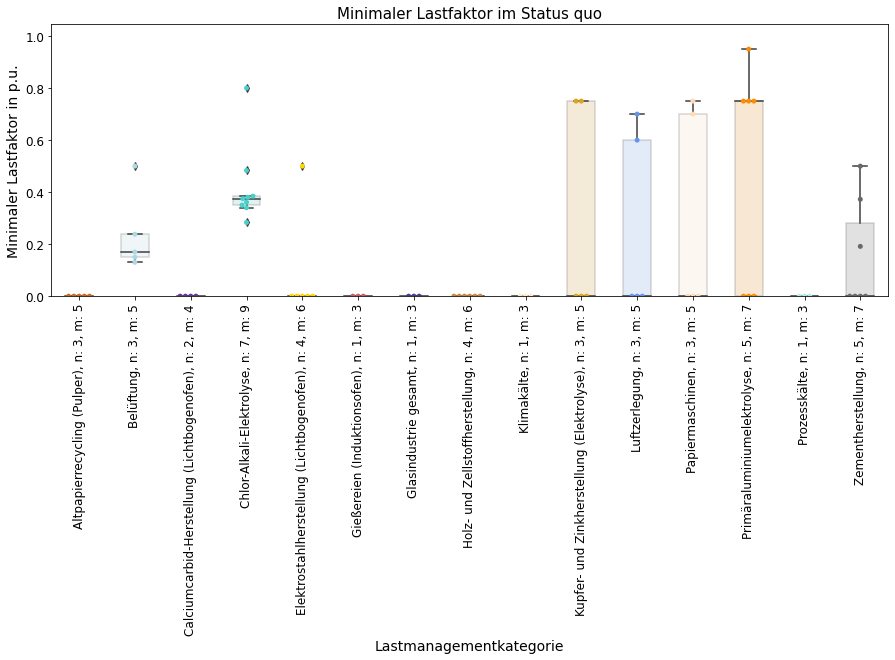

In [49]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Minimaler Lastfaktor",
    plot_ylabel="Minimaler Lastfaktor in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Maximum load values

In [50]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="max_load_ind_stats",
    file_name_sources="max_load_ind_sources",
    filter_sector=filter_sector
)

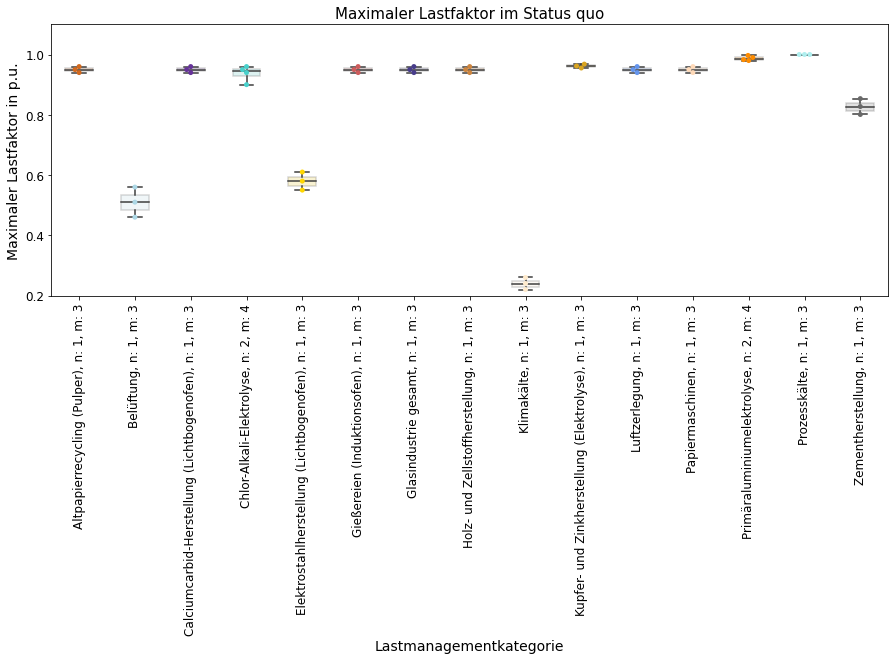

In [51]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximaler Lastfaktor",
    plot_ylabel="Maximaler Lastfaktor in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Installed capacity

In [52]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="installed_cap_ind_stats",
    file_name_sources="installed_cap_ind_sources",
    filter_sector=filter_sector
)

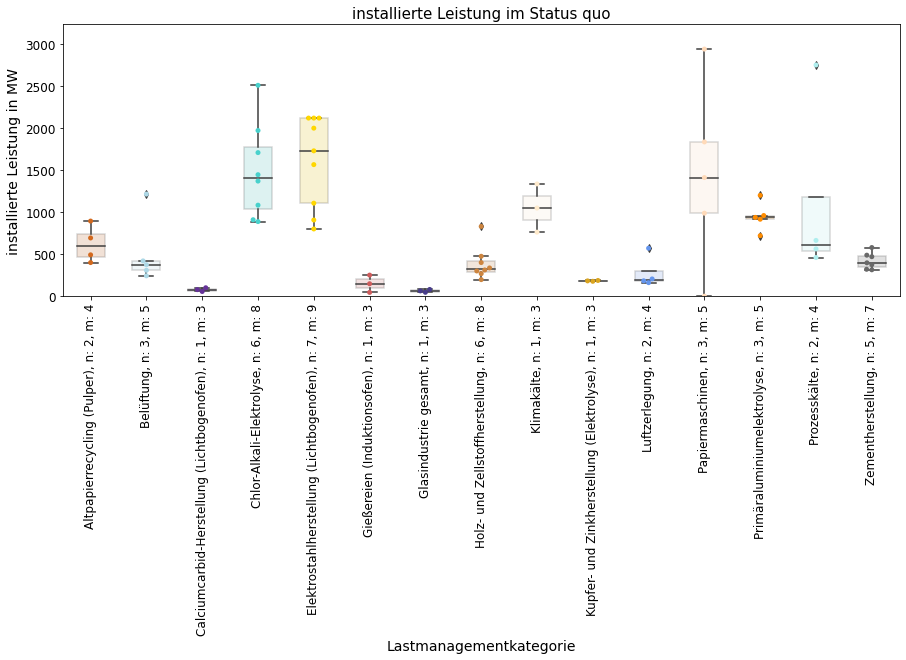

In [53]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="installierte Leistung",
    plot_ylabel="installierte Leistung in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Shiftable share

In [54]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="shiftable_share_ind_stats",
    file_name_sources="shiftable_share_ind_sources",
    filter_sector=filter_sector
)

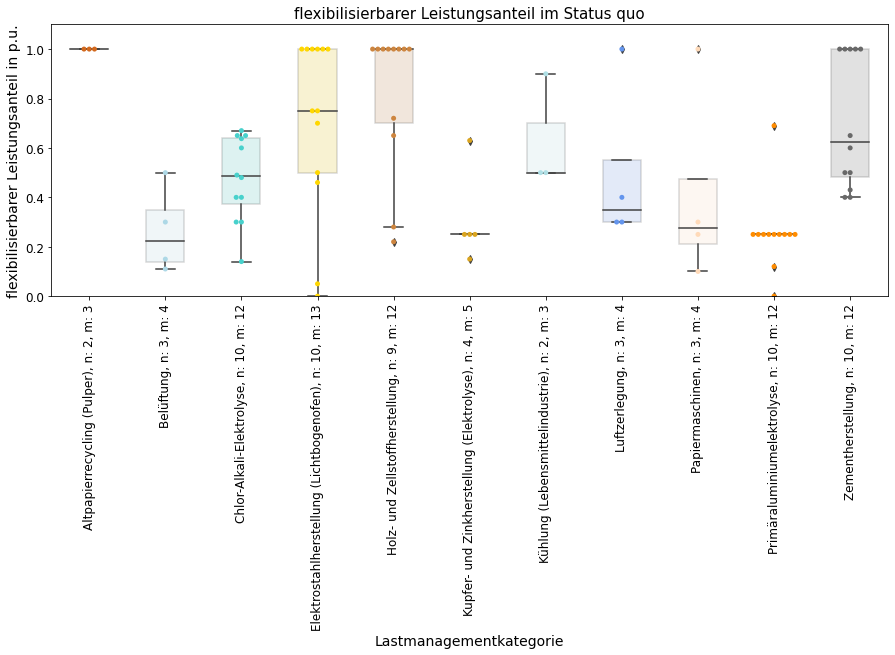

In [55]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="flexibilisierbarer Leistungsanteil",
    plot_ylabel="flexibilisierbarer Leistungsanteil in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

## Trade, commerce and services

### Positive load shift potential

In [56]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_tcs_stats",
    file_name_sources="potential_pos_ave_tcs_sources",
    filter_sector=filter_sector
)

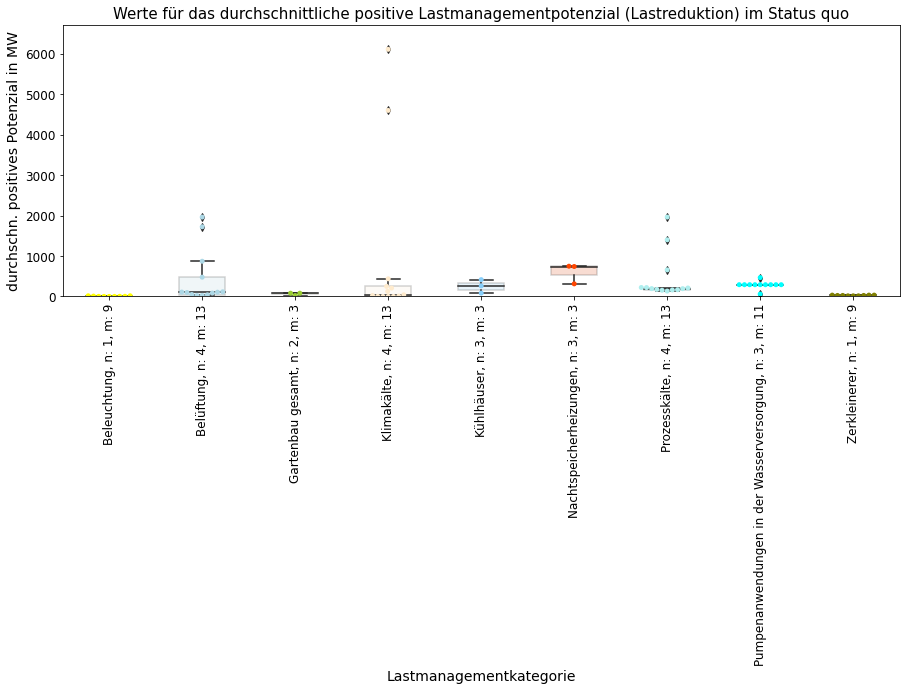

In [57]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das durchschnittliche positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [58]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_tcs_stats",
    file_name_sources="potential_pos_min_tcs_sources",
    filter_sector=filter_sector
)

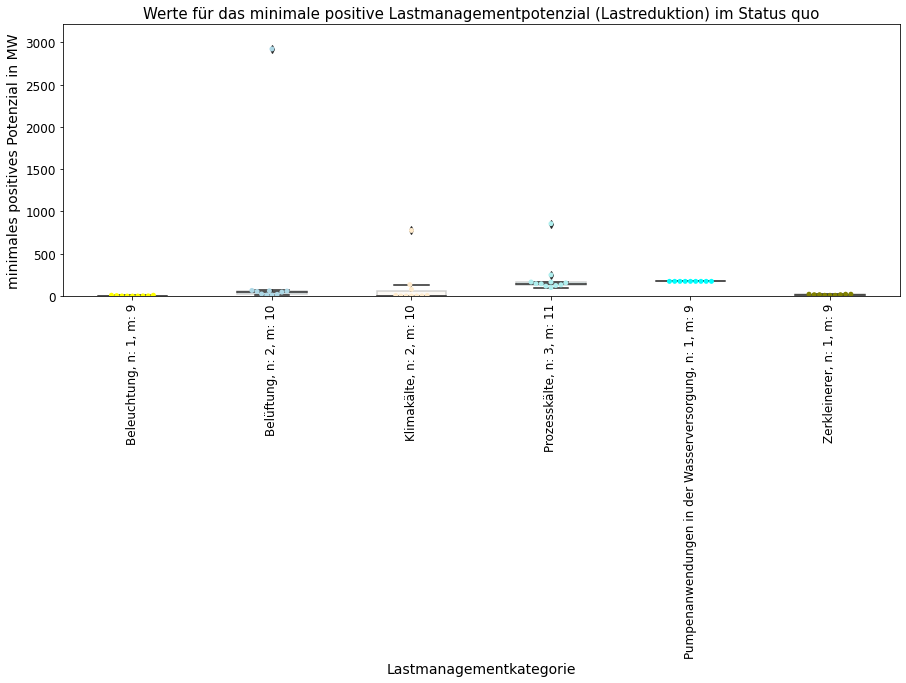

In [59]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [60]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_tcs_stats",
    file_name_sources="potential_pos_max_tcs_sources",
    filter_sector=filter_sector
)

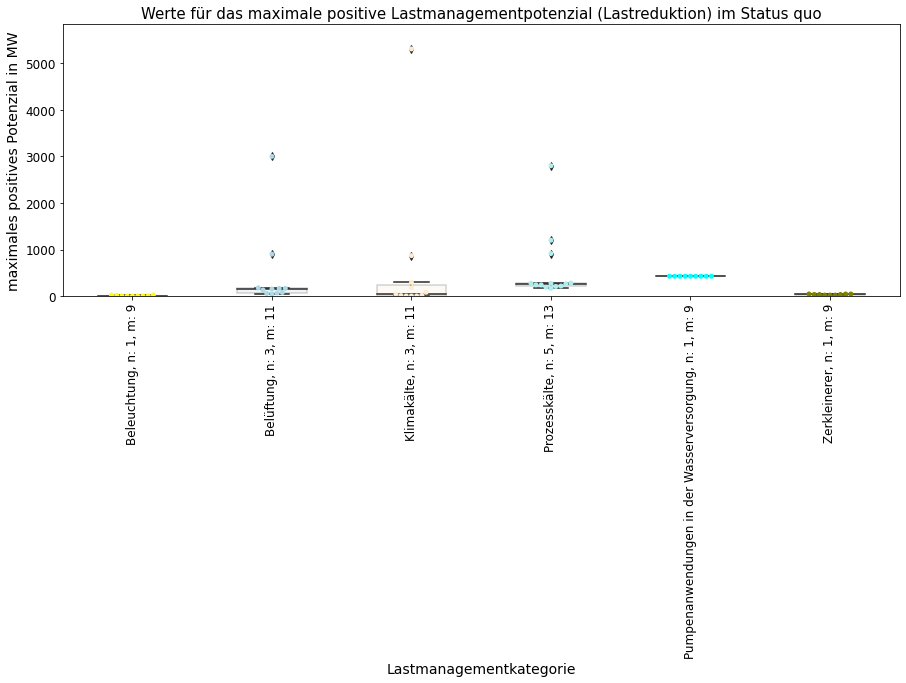

In [61]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [62]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", 
                "Potenzial positiv max"],
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_tcs_stats",
    file_name_sources="potential_pos_overall_tcs_sources",
    filter_sector=filter_sector
)

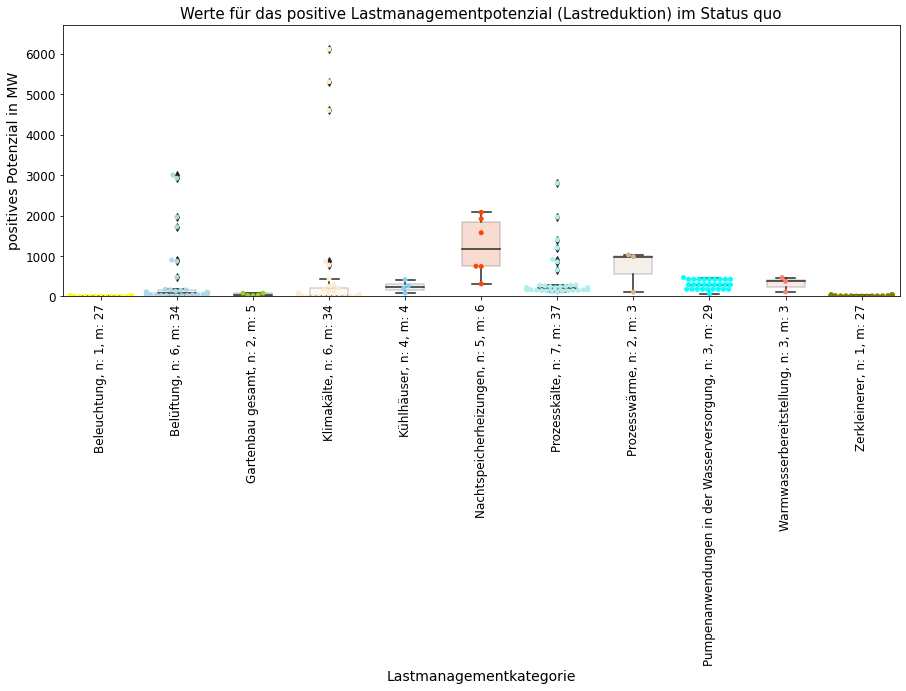

In [63]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", 
                "Potenzial positiv max"],
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Positive load shedding potential

In [64]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_shed_tcs_stats",
    file_name_sources="potential_pos_ave_shed_tcs_sources",
    filter_sector=filter_sector
)

In [65]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche positive "
        "Abschaltpotenzial (Lastverzicht)"
    ),
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


In [66]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_shed_tcs_stats",
    file_name_sources="potential_pos_min_shed_tcs_sources",
    filter_sector=filter_sector
)

In [67]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


In [68]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_shed_tcs_stats",
    file_name_sources="potential_pos_max_shed_tcs_sources",
    filter_sector=filter_sector
)

In [69]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


In [70]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht", 
        "Potenzial positiv min Lastverzicht", 
        "Potenzial positiv max Lastverzicht"
    ],
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_shed_tcs_stats",
    file_name_sources="potential_pos_overall_shed_tcs_sources",
    filter_sector=filter_sector
)

In [71]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht",
        "Potenzial positiv min Lastverzicht",
        "Potenzial positiv max Lastverzicht"],
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


### Negative load shift potential

In [72]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_neg_ave_tcs_stats",
    file_name_sources="potential_neg_ave_tcs_sources",
    filter_sector=filter_sector
)

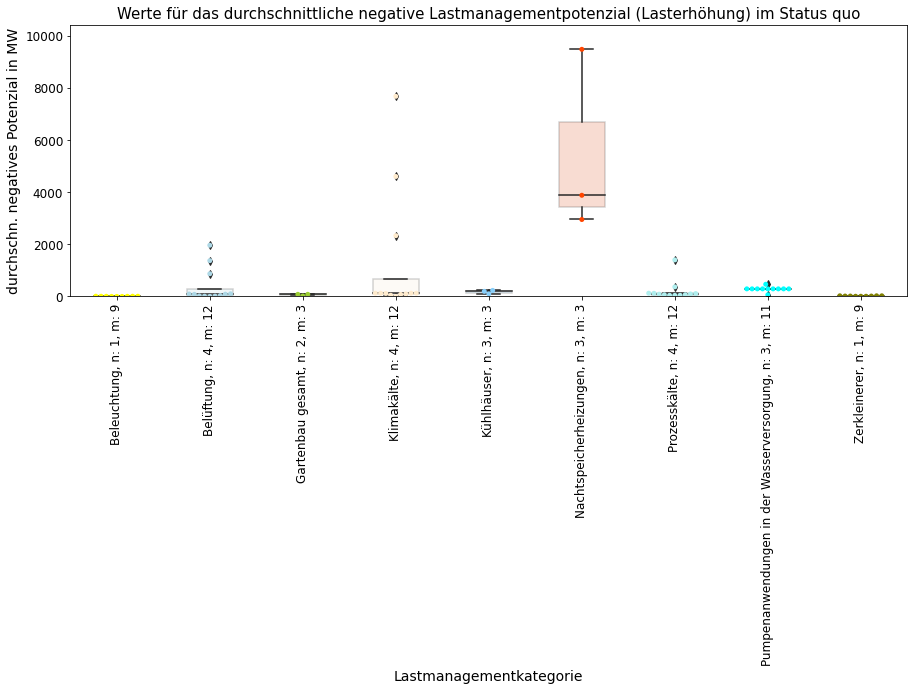

In [73]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche negative "
        "Lastmanagementpotenzial (Lasterhöhung)"
    ),
    plot_ylabel="durchschn. negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [74]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_neg_min_tcs_stats",
    file_name_sources="potential_neg_min_tcs_sources",
    filter_sector=filter_sector
)

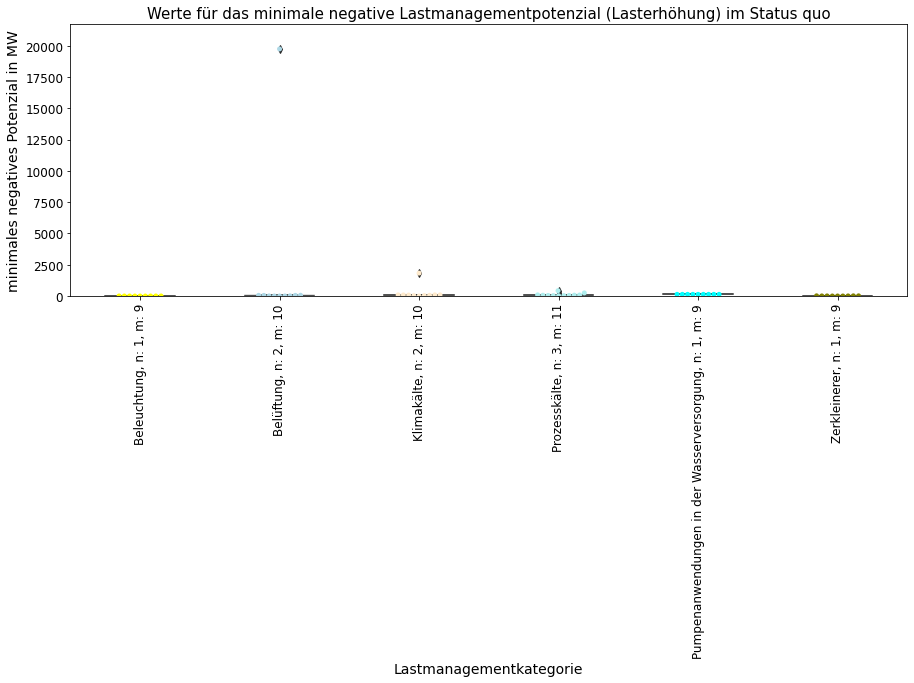

In [75]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="minimales negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [76]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_neg_max_tcs_stats",
    file_name_sources="potential_neg_max_tcs_sources",
    filter_sector=filter_sector
)

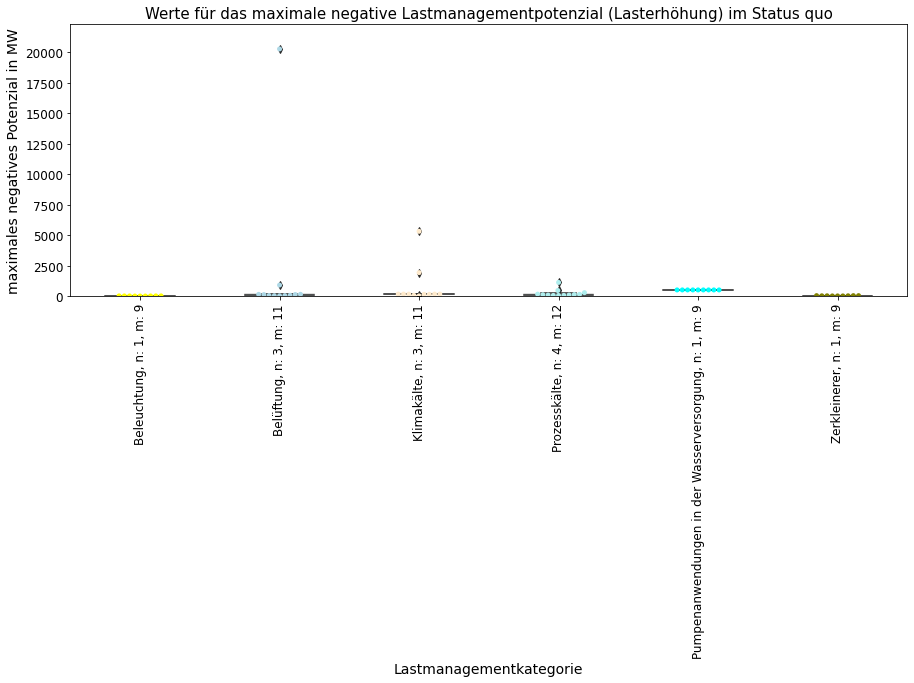

In [77]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="maximales negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [78]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_neg_overall_tcs_stats",
    file_name_sources="potential_neg_overall_tcs_sources",
    filter_sector=filter_sector
)

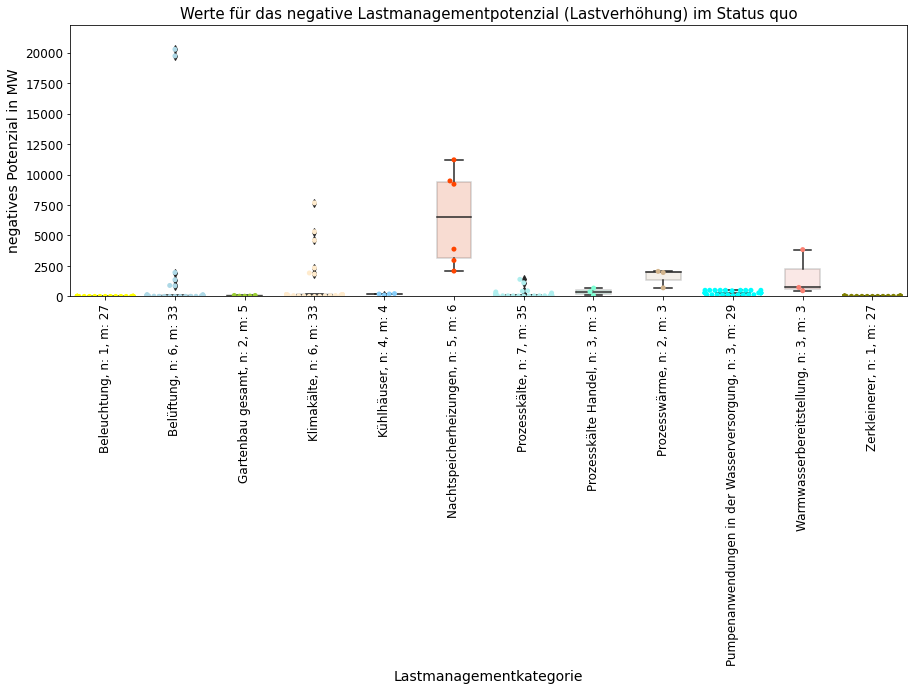

In [79]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das negative Lastmanagementpotenzial (Lastverhöhung)",
    plot_ylabel="negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Average load values

In [80]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="ave_load_tcs_stats",
    file_name_sources="ave_load_tcs_sources",
    filter_sector=filter_sector
)

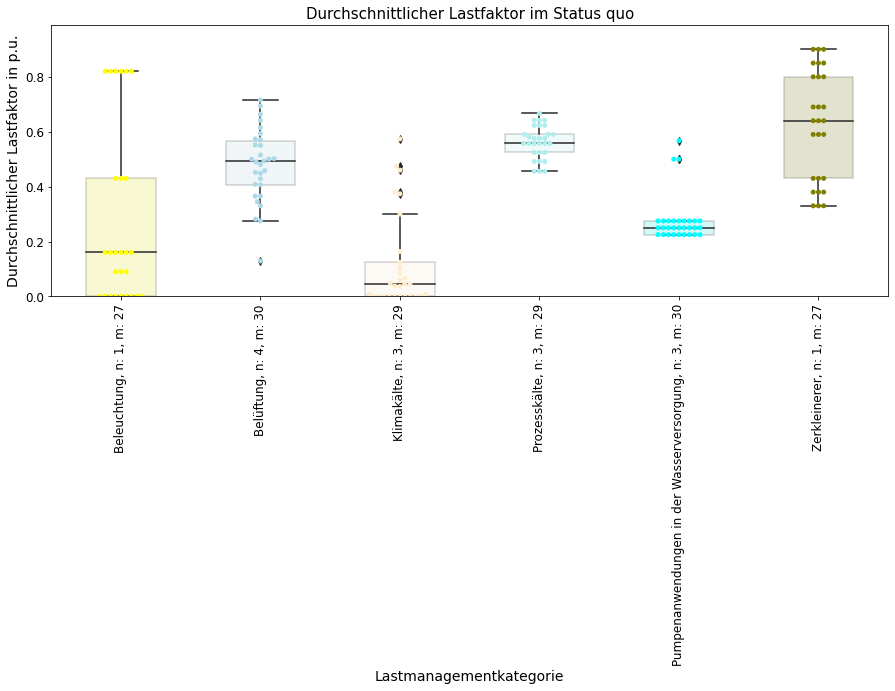

In [81]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Durchschnittlicher Lastfaktor",
    plot_ylabel="Durchschnittlicher Lastfaktor in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Minimum load values

In [82]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="min_load_tcs_stats",
    file_name_sources="min_load_tcs_sources",
    filter_sector=filter_sector
)

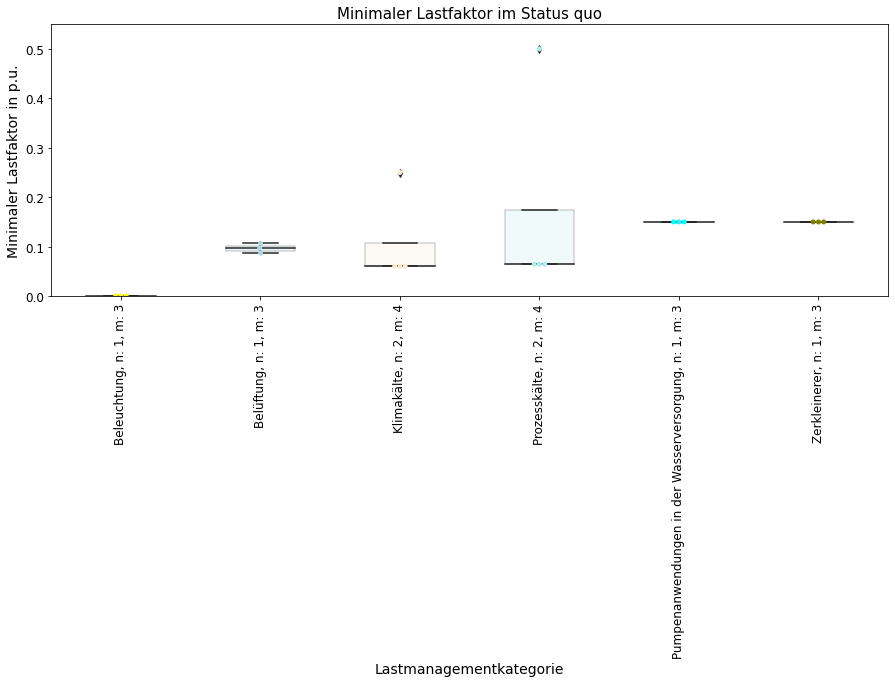

In [83]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Minimaler Lastfaktor",
    plot_ylabel="Minimaler Lastfaktor in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Maximum load values

In [84]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="max_load_tcs_stats",
    file_name_sources="max_load_tcs_sources",
    filter_sector=filter_sector
)

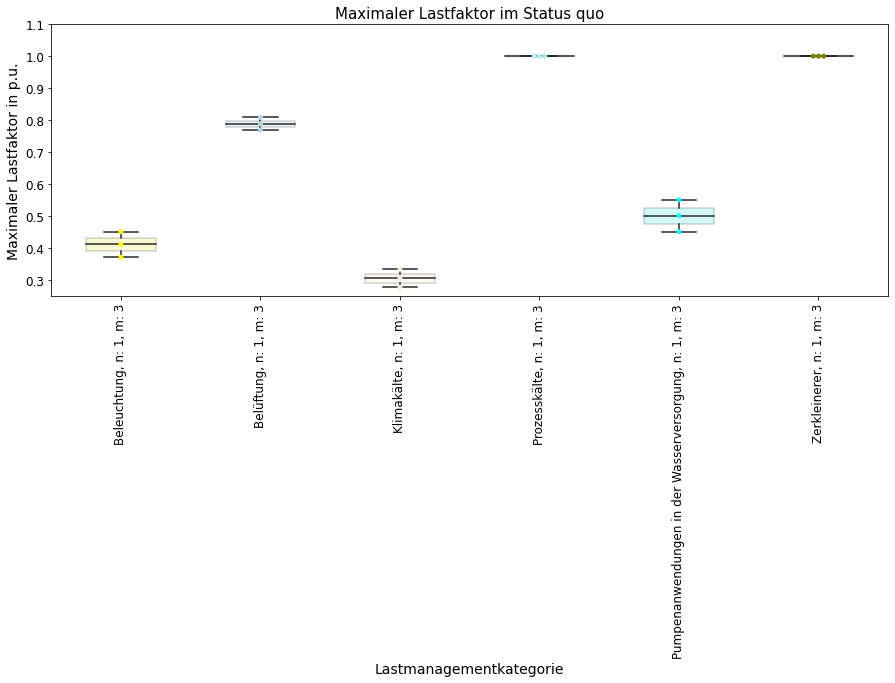

In [85]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximaler Lastfaktor",
    plot_ylabel="Maximaler Lastfaktor in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Installed capacity

In [86]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="installed_cap_tcs_stats",
    file_name_sources="installed_cap_tcs_sources",
    filter_sector=filter_sector
)

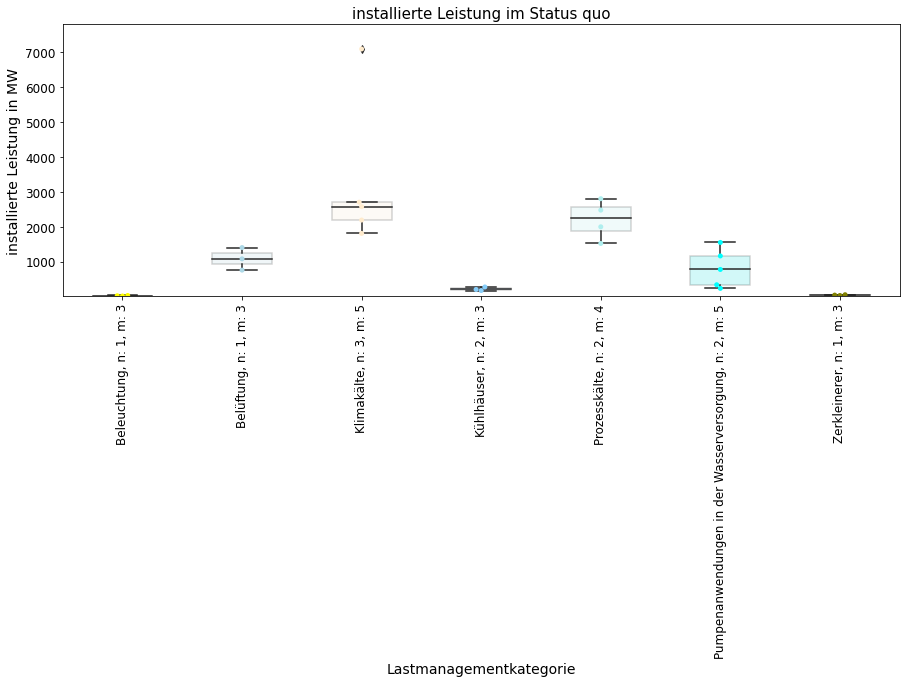

In [87]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="installierte Leistung",
    plot_ylabel="installierte Leistung in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Shiftable share

In [88]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="shiftable_share_tcs_stats",
    file_name_sources="shiftable_share_tcs_sources",
    filter_sector=filter_sector
)

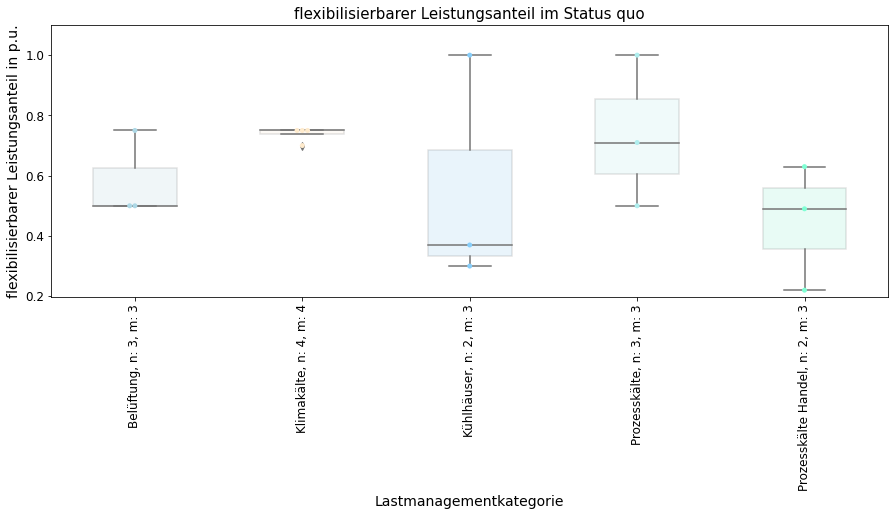

In [89]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="flexibilisierbarer Leistungsanteil",
    plot_ylabel="flexibilisierbarer Leistungsanteil in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

## Households

### Positive load shift potential

In [90]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_hoho_stats",
    file_name_sources="potential_pos_ave_hoho_sources",
    filter_sector=filter_sector
)

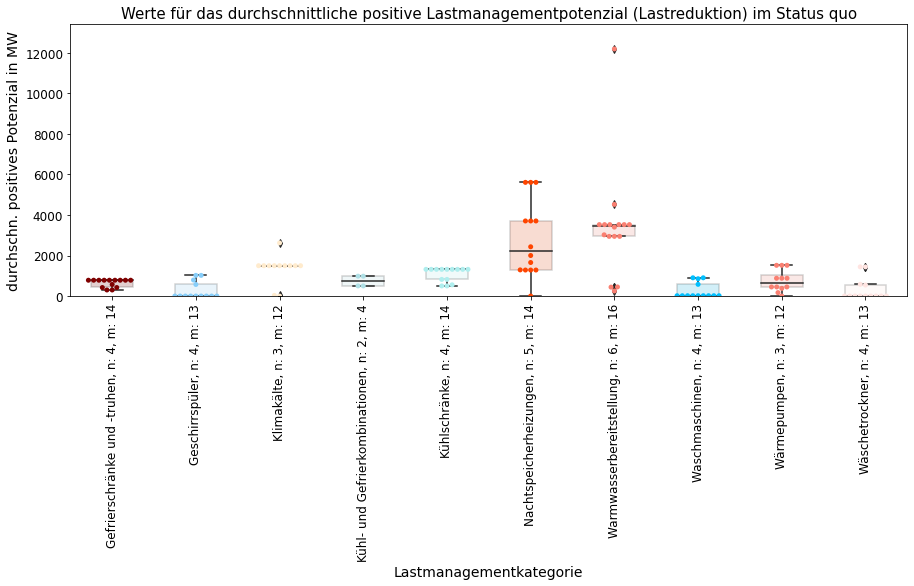

In [91]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das durchschnittliche positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [92]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_hoho_stats",
    file_name_sources="potential_pos_min_hoho_sources",
    filter_sector=filter_sector
)

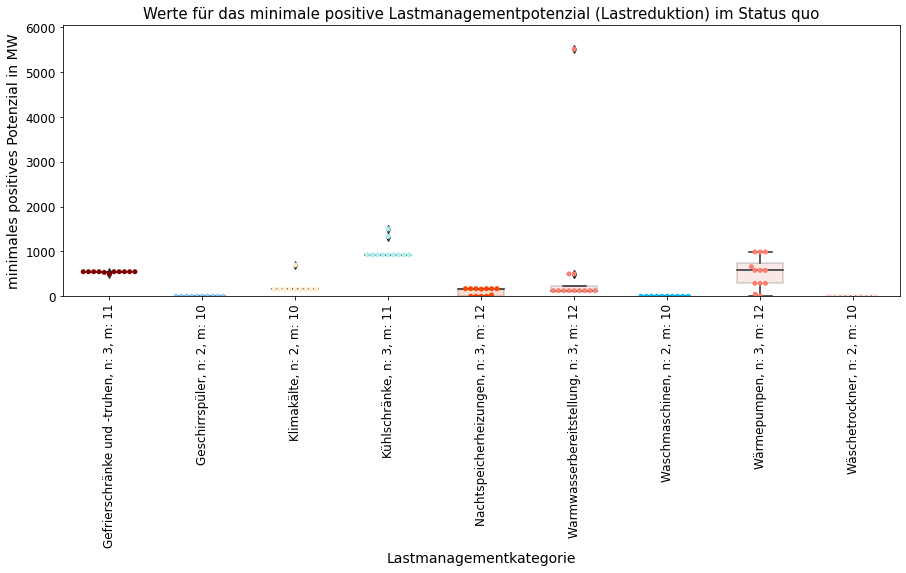

In [93]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [94]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_hoho_stats",
    file_name_sources="potential_pos_max_hoho_sources",
    filter_sector=filter_sector
)

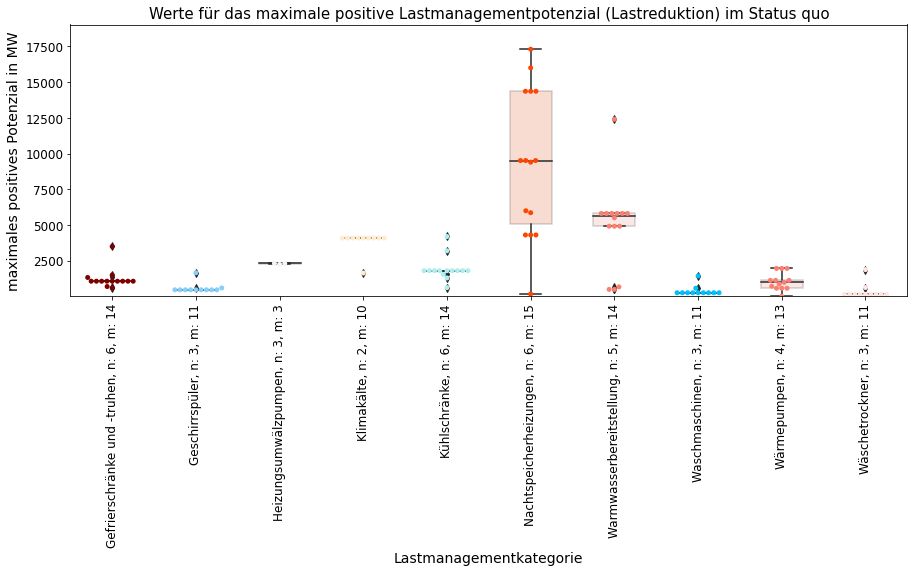

In [95]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [96]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", 
                "Potenzial positiv max"],
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_hoho_stats",
    file_name_sources="potential_pos_overall_hoho_sources",
    filter_sector=filter_sector
)

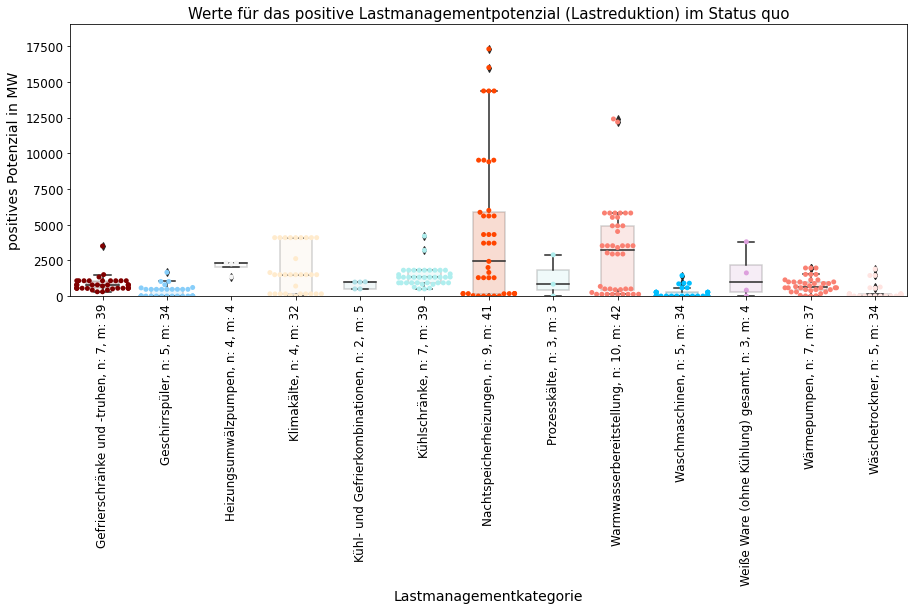

In [97]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", 
                "Potenzial positiv max"],
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Positive load shedding potential

In [98]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_shed_hoho_stats",
    file_name_sources="potential_pos_ave_shed_hoho_sources",
    filter_sector=filter_sector
)

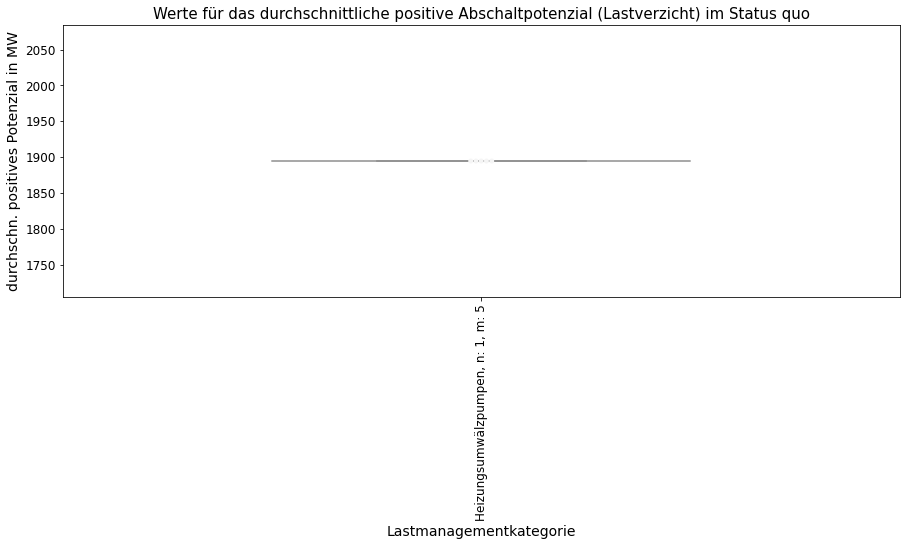

In [99]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche positive "
        "Abschaltpotenzial (Lastverzicht)"
    ),
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [100]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_shed_hoho_stats",
    file_name_sources="potential_pos_min_shed_hoho_sources",
    filter_sector=filter_sector
)

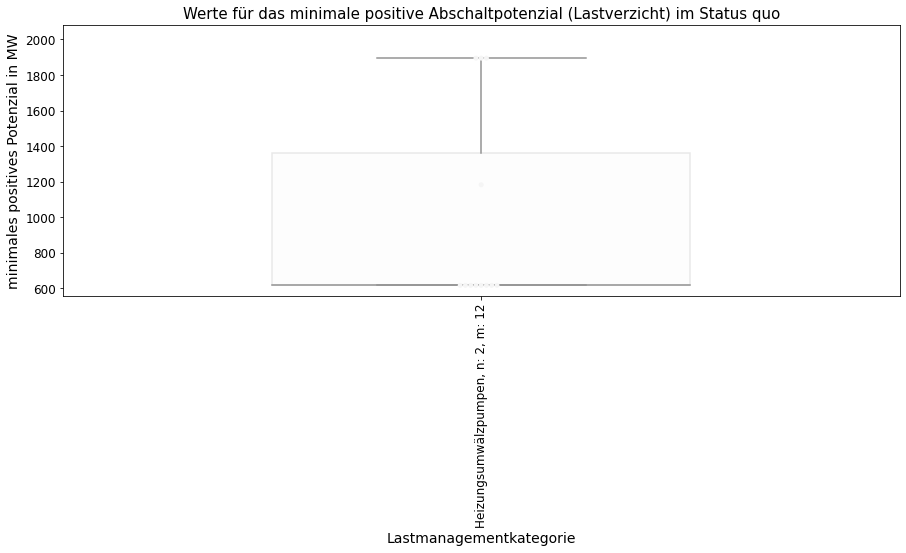

In [101]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [102]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_shed_hoho_stats",
    file_name_sources="potential_pos_max_shed_hoho_sources",
    filter_sector=filter_sector
)

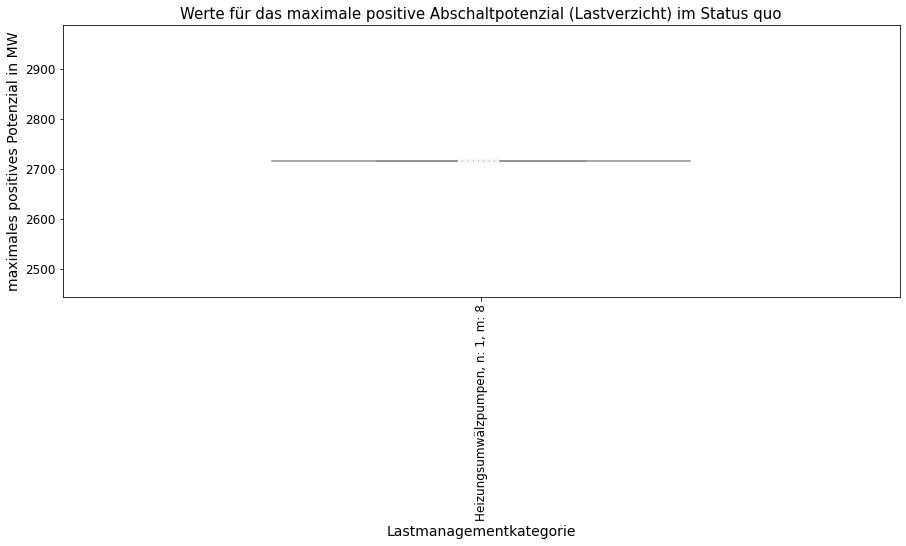

In [103]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [104]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht", 
        "Potenzial positiv min Lastverzicht", 
        "Potenzial positiv max Lastverzicht"
    ],
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_shed_hoho_stats",
    file_name_sources="potential_pos_overall_shed_hoho_sources",
    filter_sector=filter_sector
)

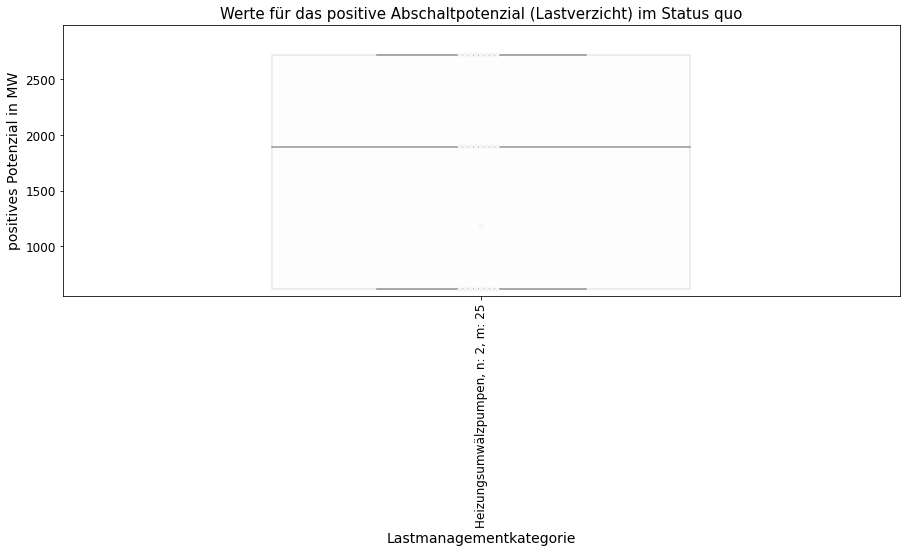

In [105]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht",
        "Potenzial positiv min Lastverzicht",
        "Potenzial positiv max Lastverzicht"],
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Negative load shift potential

In [106]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_neg_ave_hoho_stats",
    file_name_sources="potential_neg_ave_hoho_sources",
    filter_sector=filter_sector
)

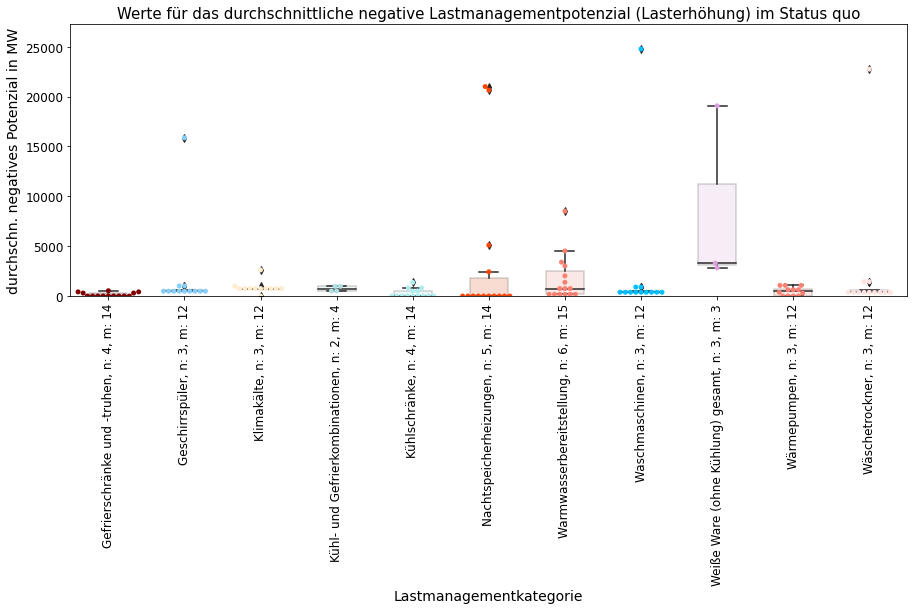

In [107]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche negative "
        "Lastmanagementpotenzial (Lasterhöhung)"
    ),
    plot_ylabel="durchschn. negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [108]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_neg_min_hoho_stats",
    file_name_sources="potential_neg_min_hoho_sources",
    filter_sector=filter_sector
)

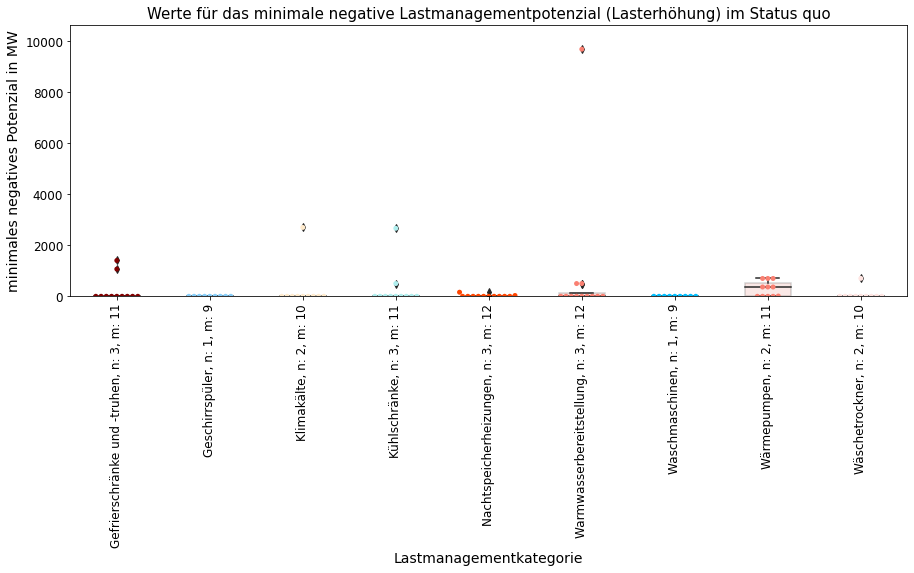

In [109]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="minimales negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [110]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_neg_max_hoho_stats",
    file_name_sources="potential_neg_max_hoho_sources",
    filter_sector=filter_sector
)

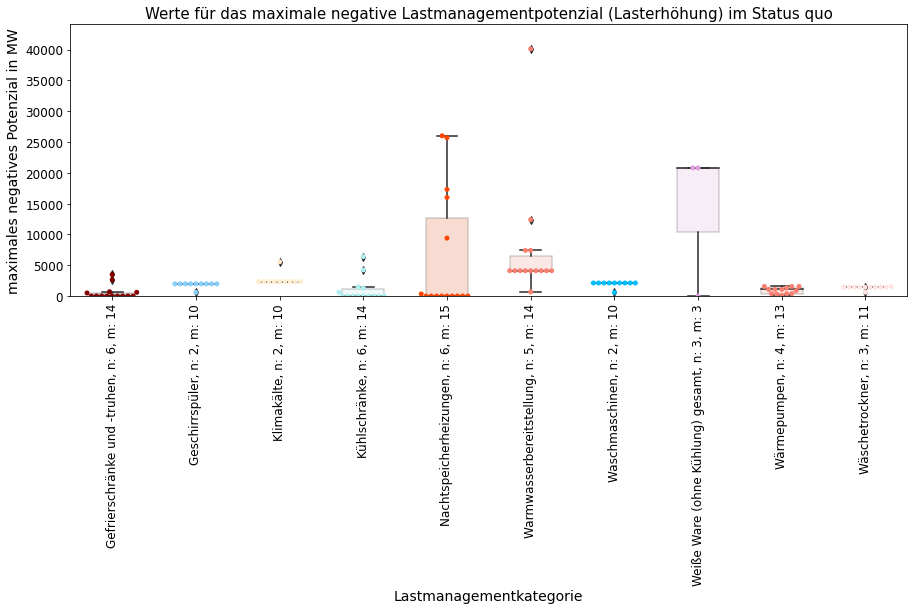

In [111]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="maximales negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

In [112]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_neg_overall_hoho_stats",
    file_name_sources="potential_neg_overall_hoho_sources",
    filter_sector=filter_sector
)

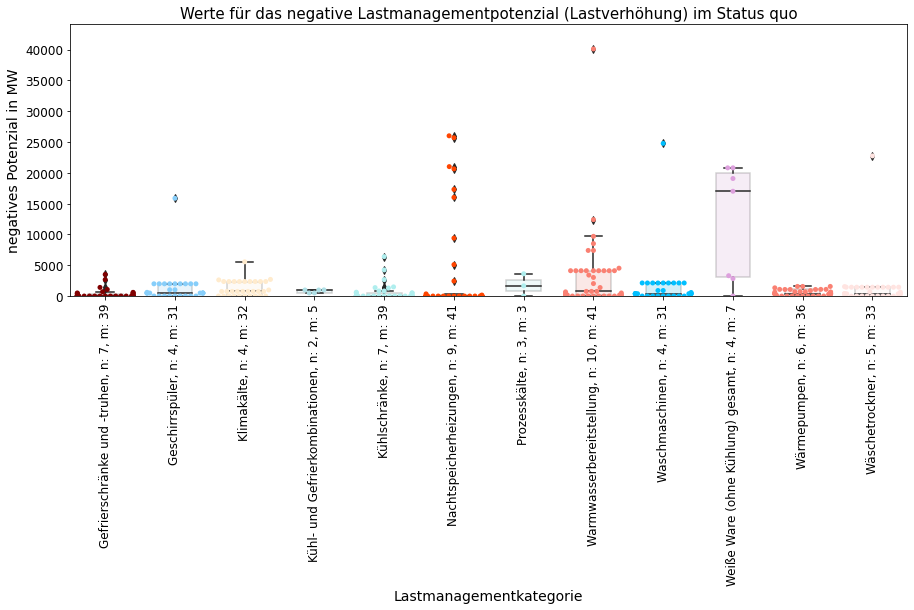

In [113]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das negative Lastmanagementpotenzial (Lastverhöhung)",
    plot_ylabel="negatives Potenzial in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Average load values

In [114]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="ave_load_hoho_stats",
    file_name_sources="ave_load_hoho_sources",
    filter_sector=filter_sector
)

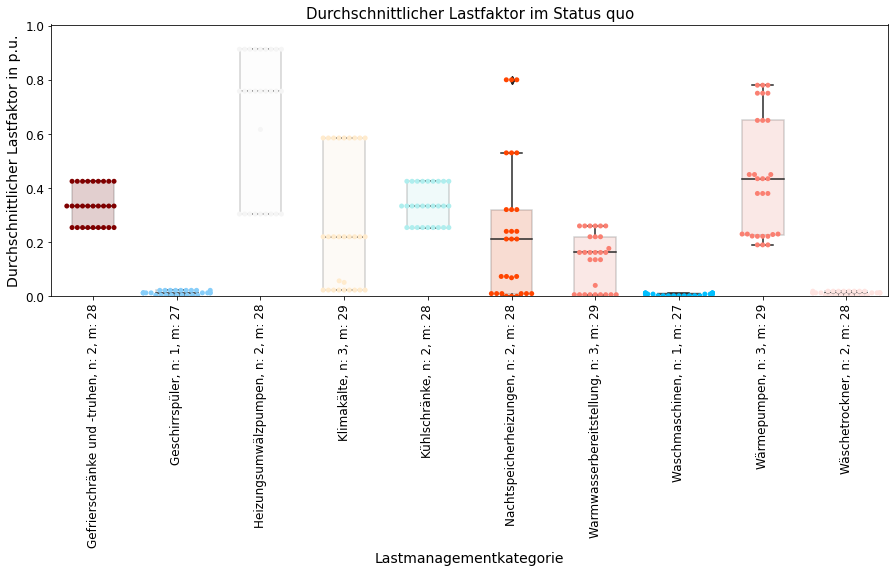

In [115]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Durchschnittlicher Lastfaktor",
    plot_ylabel="Durchschnittlicher Lastfaktor in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Minimum load values

In [116]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="min_load_hoho_stats",
    file_name_sources="min_load_hoho_sources",
    filter_sector=filter_sector
)

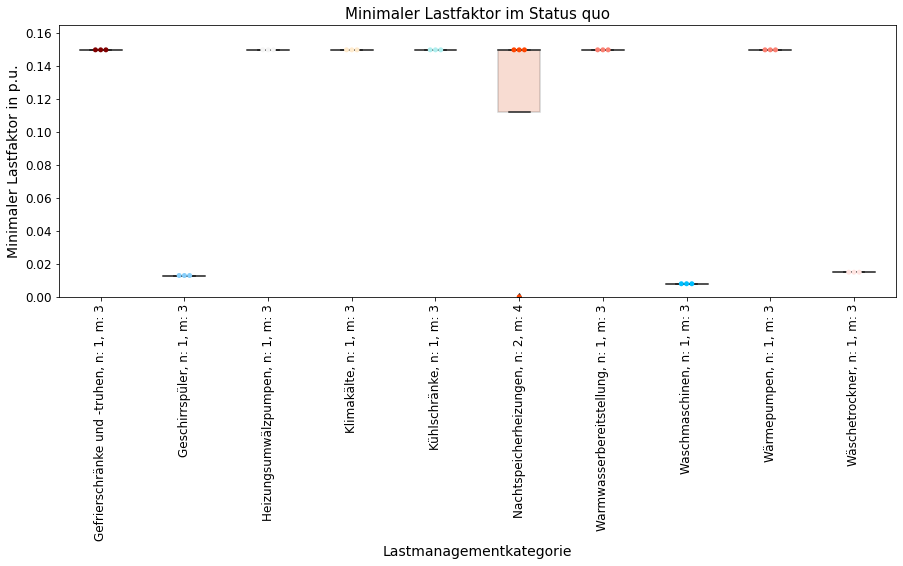

In [117]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Minimaler Lastfaktor",
    plot_ylabel="Minimaler Lastfaktor in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Maximum load values

In [118]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="max_load_hoho_stats",
    file_name_sources="max_load_hoho_sources",
    filter_sector=filter_sector
)

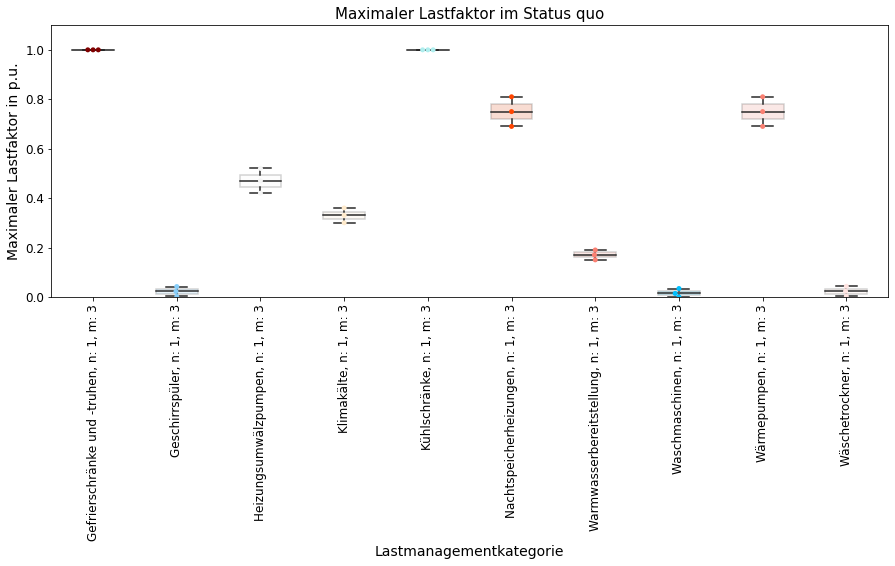

In [119]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximaler Lastfaktor",
    plot_ylabel="Maximaler Lastfaktor in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Installed capacity

In [120]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="installed_cap_hoho_stats",
    file_name_sources="installed_cap_hoho_sources",
    filter_sector=filter_sector
)

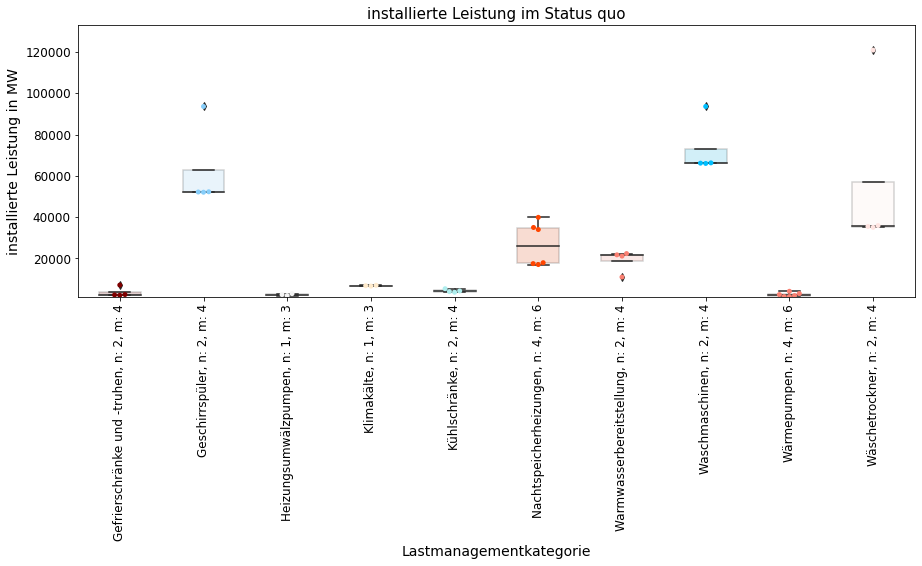

In [121]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="installierte Leistung",
    plot_ylabel="installierte Leistung in MW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### Shiftable share

In [122]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="shiftable_share_hoho_stats",
    file_name_sources="shiftable_share_hoho_sources",
    filter_sector=filter_sector
)

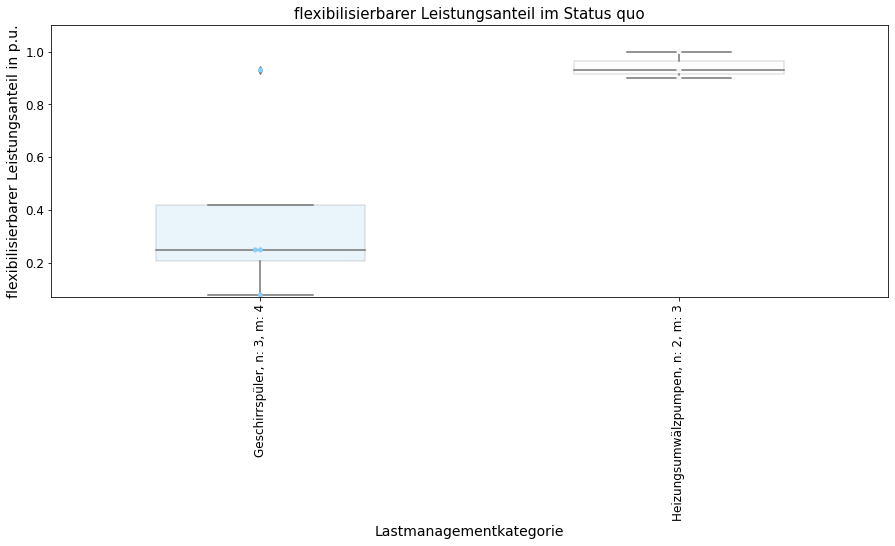

In [123]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="flexibilisierbarer Leistungsanteil",
    plot_ylabel="flexibilisierbarer Leistungsanteil in p.u.",
    plot_colors=colors,
    filter_sector=filter_sector
)

# Time-related parameters
In the following, all time-related demand response parameters are evaluated. These comprise
* activation duration (in h),
* interference duration in postive (shifting and shedding) and negative direction (in h),
* shifting duration (in h),
* regeneration duration (in h) as well as
* maximum activations per year (for shifting and shedding) (in 1).

The evaluation is carried out per process / appliance for a given sector and year.

## Industry

### Activation duration

In [124]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="activation_duration_ind_stats",
    file_name_sources="activation_duration_ind_sources",
    filter_sector=filter_sector
)

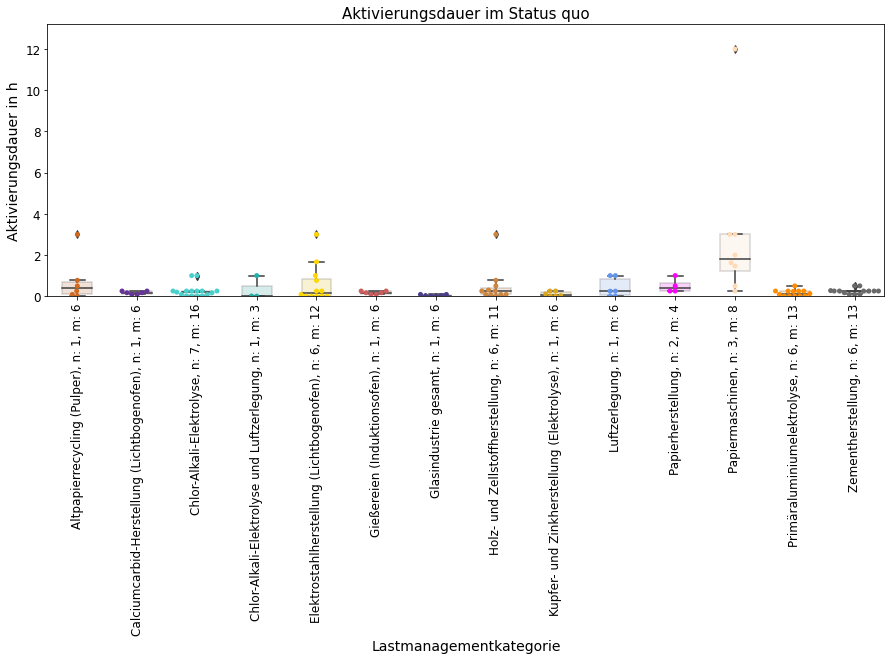

In [125]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Aktivierungsdauer",
    plot_ylabel="Aktivierungsdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### interference duration positive load shifting

In [126]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_ind_stats",
    file_name_sources="interference_duration_pos_ind_sources",
    filter_sector=filter_sector
)

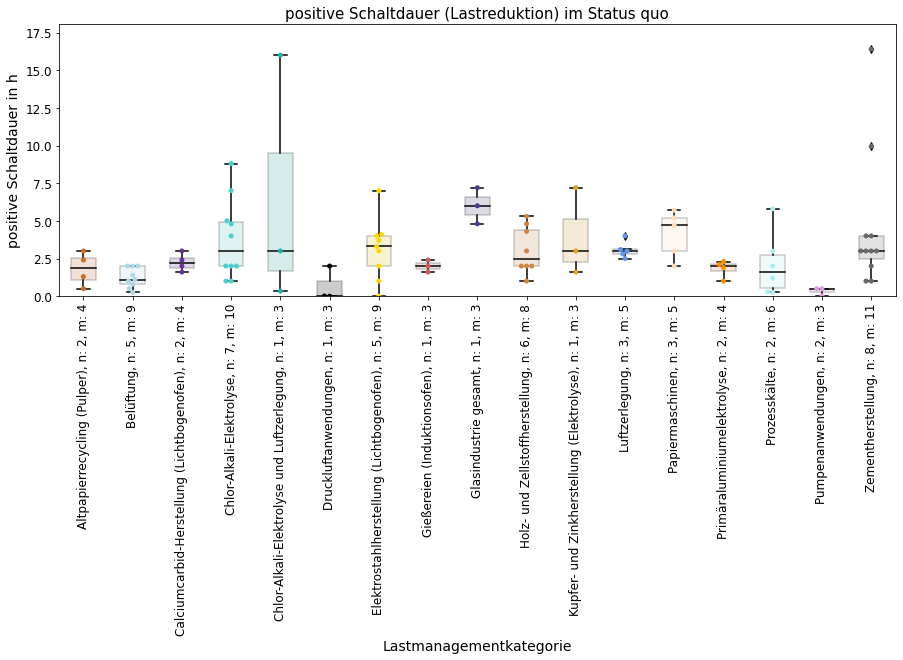

In [127]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastreduktion)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### interference duration positive load shedding

In [128]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_shed_ind_stats",
    file_name_sources="interference_duration_pos_shed_ind_sources",
    filter_sector=filter_sector
)

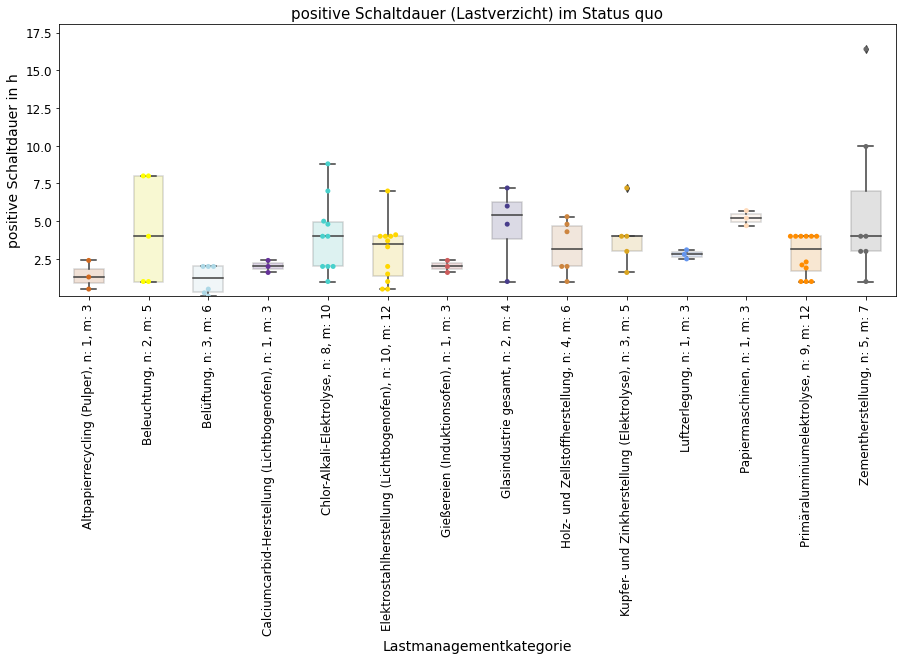

In [129]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastverzicht)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### interference duration negative

In [130]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="interference_duration_neg_ind_stats",
    file_name_sources="interference_duration_neg_ind_sources",
    filter_sector=filter_sector
)

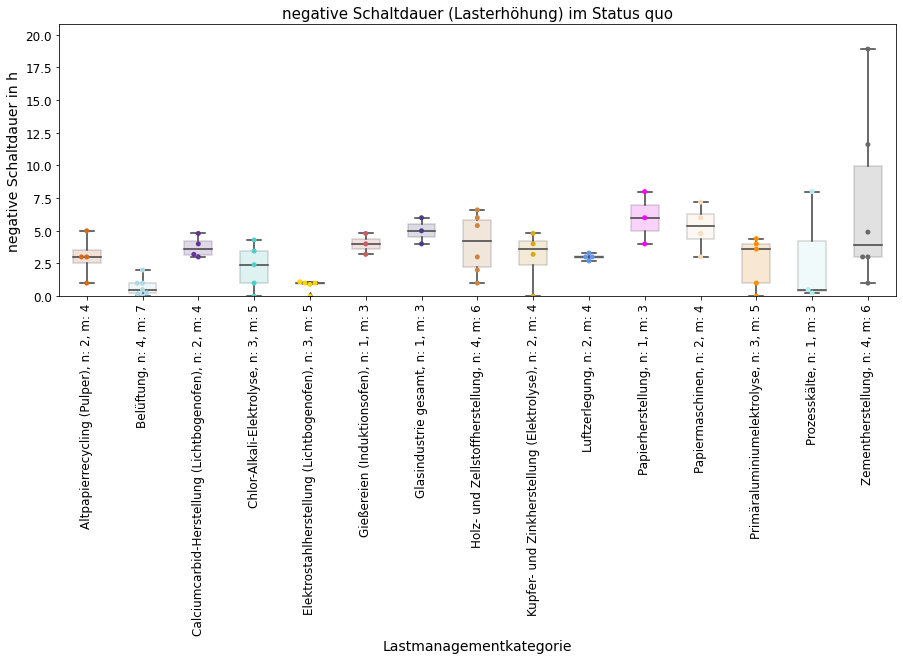

In [131]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="negative Schaltdauer (Lasterhöhung)",
    plot_ylabel="negative Schaltdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### shifting duration

In [132]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="shifting_duration_ind_stats",
    file_name_sources="shifting_duration_ind_sources",
    filter_sector=filter_sector
)

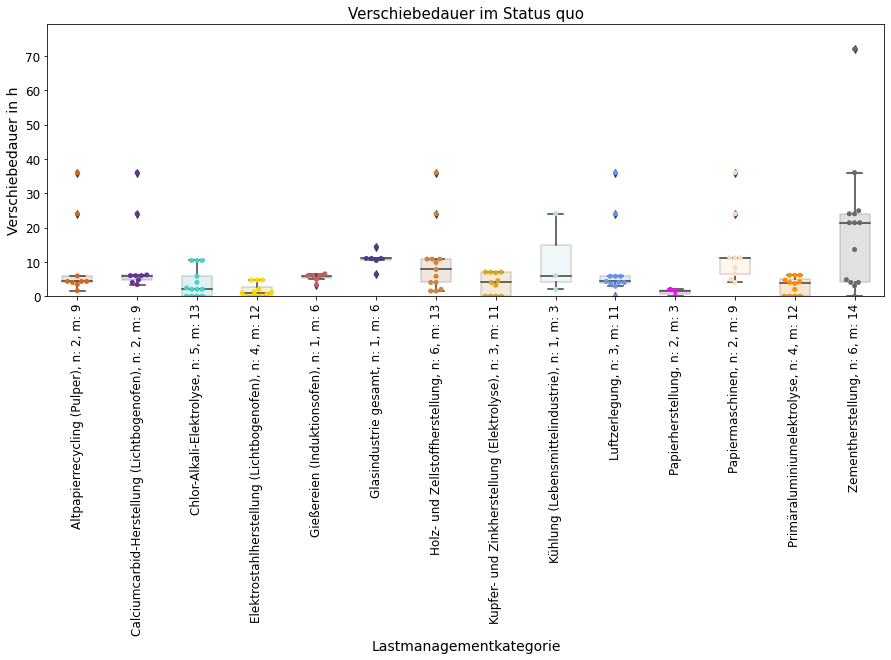

In [133]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Verschiebedauer",
    plot_ylabel="Verschiebedauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### regeneration duration

In [134]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="regeneration_duration_ind_stats",
    file_name_sources="regeneration_duration_ind_sources",
    filter_sector=filter_sector
)

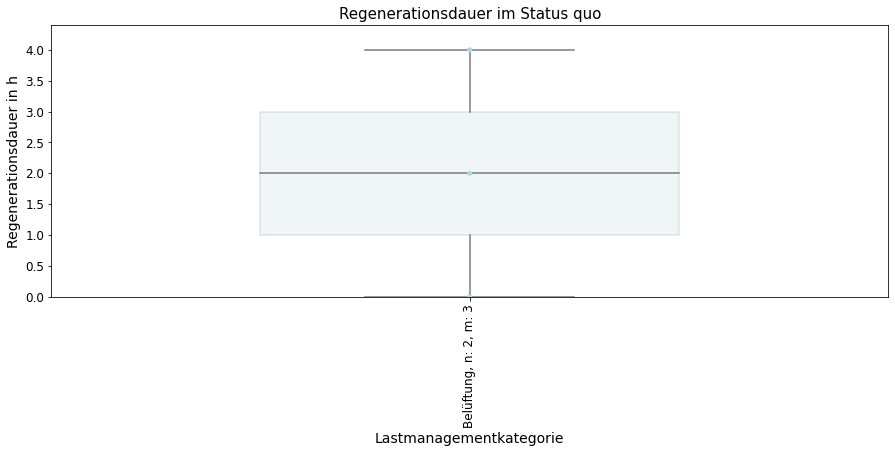

In [135]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Regenerationsdauer",
    plot_ylabel="Regenerationsdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### maximum activations per year load shifting

In [136]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_ind_stats",
    file_name_sources="maximum_activations_year_ind_sources",
    filter_sector=filter_sector
)

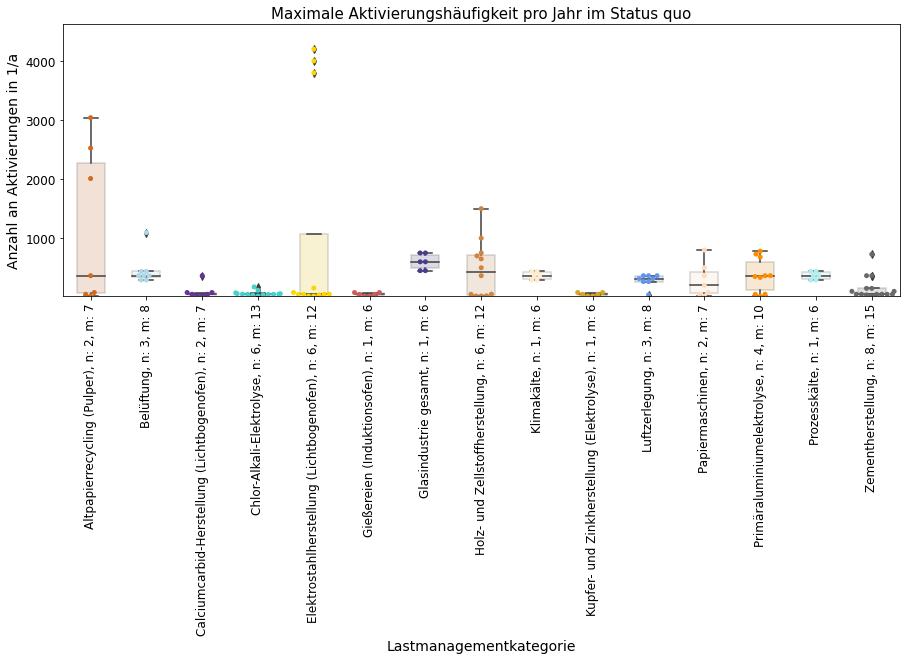

In [137]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors,
    filter_sector=filter_sector
)

### maximum activations per year load shedding

In [138]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_shed_ind_stats",
    file_name_sources="maximum_activations_year_shed_ind_sources",
    filter_sector=filter_sector
)

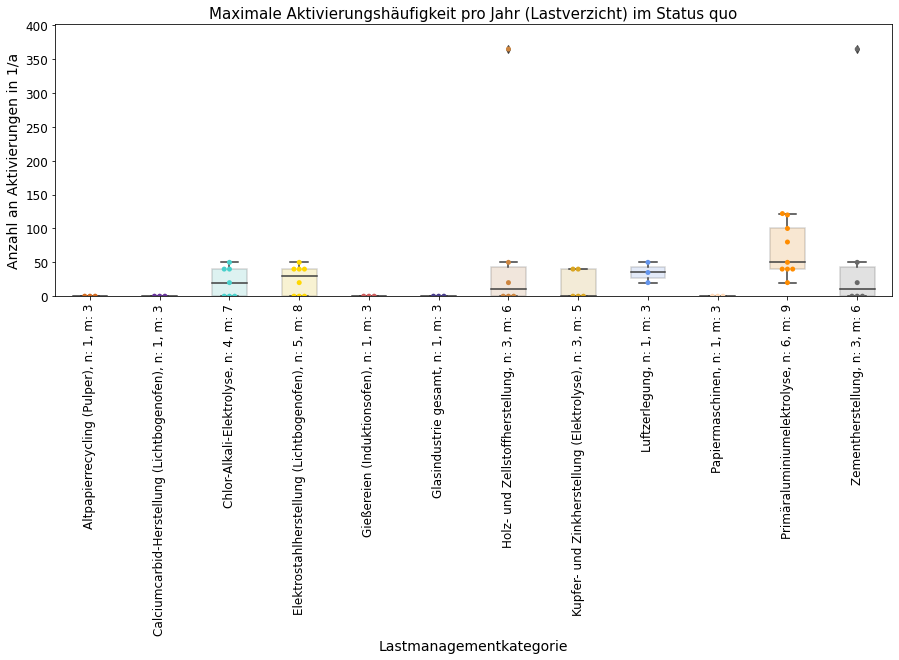

In [139]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr (Lastverzicht)",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors,
    filter_sector=filter_sector
)

## Trade, commerce and services

### Activation duration

In [140]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="activation_duration_tcs_stats",
    file_name_sources="activation_duration_tcs_sources",
    filter_sector=filter_sector
)

In [141]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Aktivierungsdauer",
    plot_ylabel="Aktivierungsdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


### interference duration positive load shifting

In [142]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_tcs_stats",
    file_name_sources="interference_duration_pos_tcs_sources",
    filter_sector=filter_sector
)

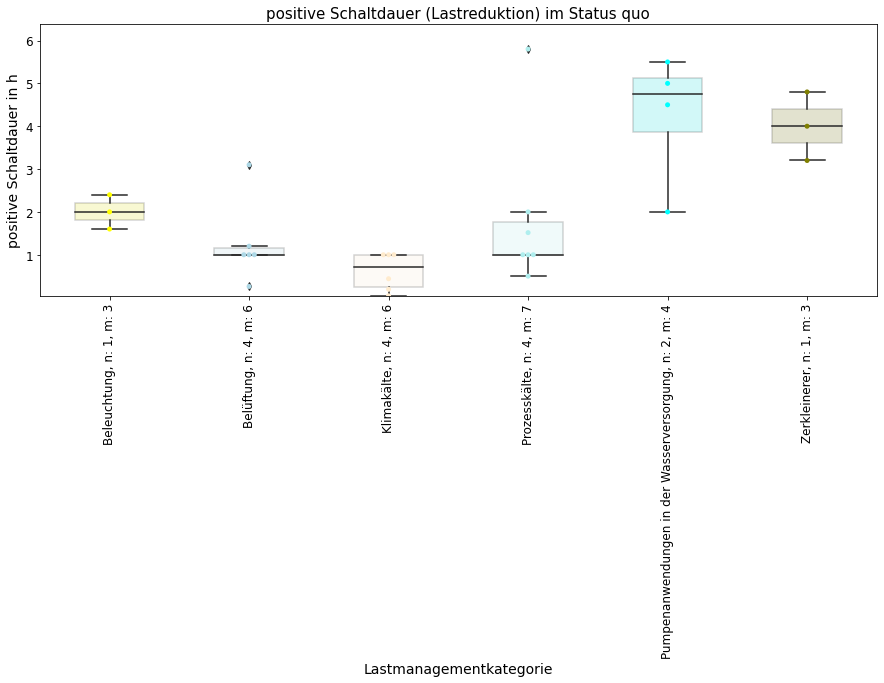

In [143]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastreduktion)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### interference duration positive load shedding

In [144]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_shed_tcs_stats",
    file_name_sources="interference_duration_pos_shed_tcs_sources",
    filter_sector=filter_sector
)

In [145]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastverzicht)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


### interference duration negative

In [146]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="interference_duration_neg_tcs_stats",
    file_name_sources="interference_duration_neg_tcs_sources",
    filter_sector=filter_sector
)

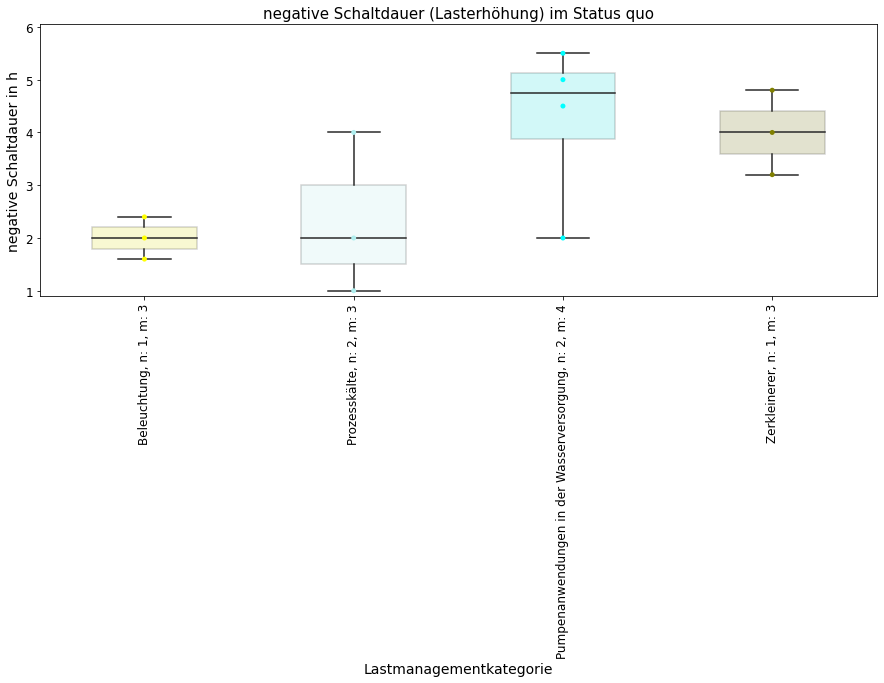

In [147]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="negative Schaltdauer (Lasterhöhung)",
    plot_ylabel="negative Schaltdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### shifting duration

In [148]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="shifting_duration_tcs_stats",
    file_name_sources="shifting_duration_tcs_sources",
    filter_sector=filter_sector
)

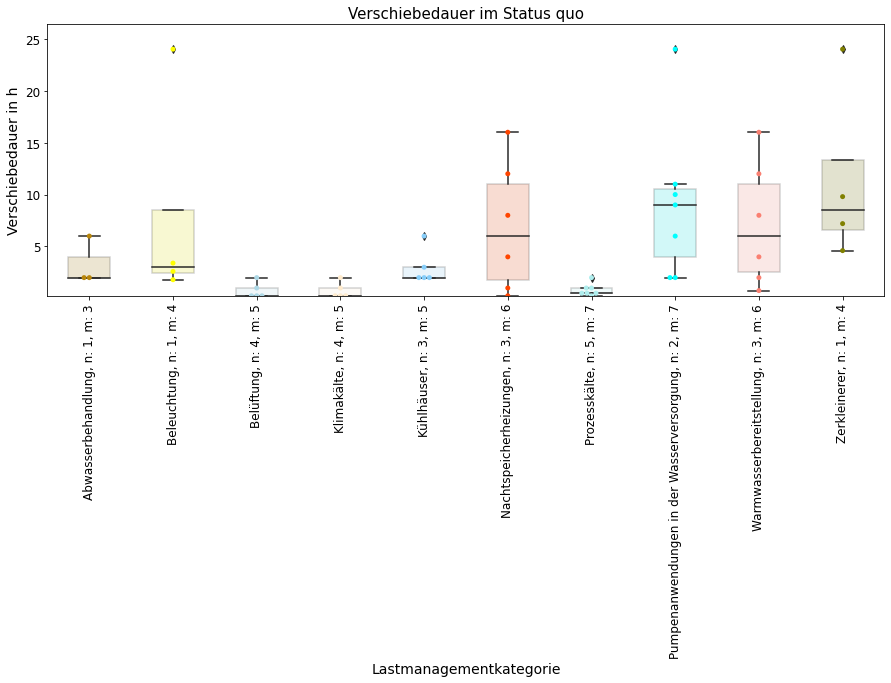

In [149]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Verschiebedauer",
    plot_ylabel="Verschiebedauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### regeneration duration

In [150]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="regeneration_duration_tcs_stats",
    file_name_sources="regeneration_duration_tcs_sources",
    filter_sector=filter_sector
)

In [151]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Regenerationsdauer",
    plot_ylabel="Regenerationsdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


### maximum activations per year load shifting

In [152]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_tcs_stats",
    file_name_sources="maximum_activations_year_tcs_sources",
    filter_sector=filter_sector
)

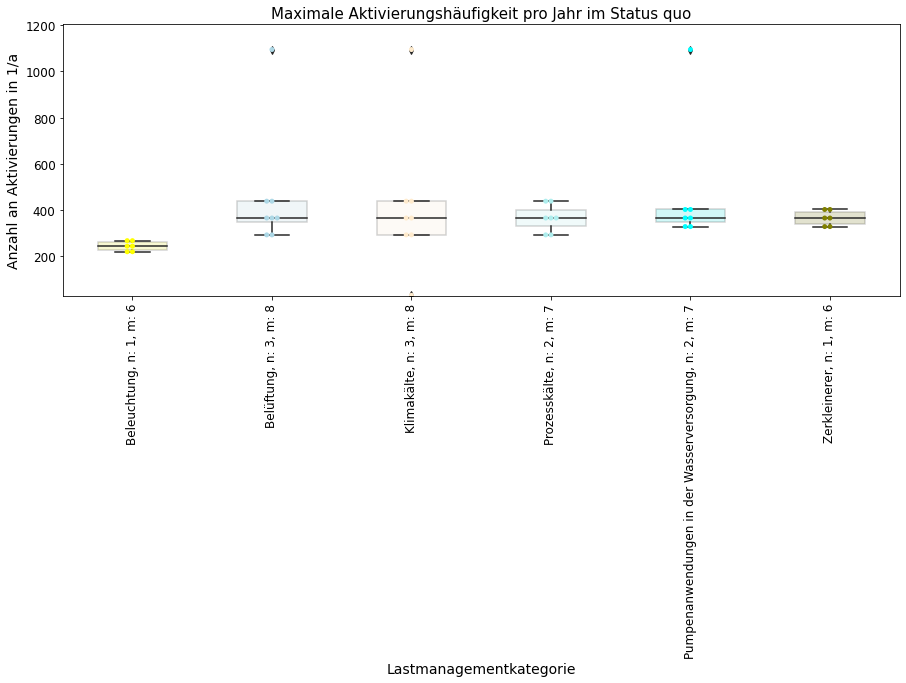

In [153]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors,
    filter_sector=filter_sector
)

### maximum activations per year load shedding

In [154]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_shed_tcs_stats",
    file_name_sources="maximum_activations_year_shed_tcs_sources",
    filter_sector=filter_sector
)

In [155]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr (Lastverzicht)",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


## Households

### Activation duration

In [156]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="activation_duration_hoho_stats",
    file_name_sources="activation_duration_hoho_sources",
    filter_sector=filter_sector
)

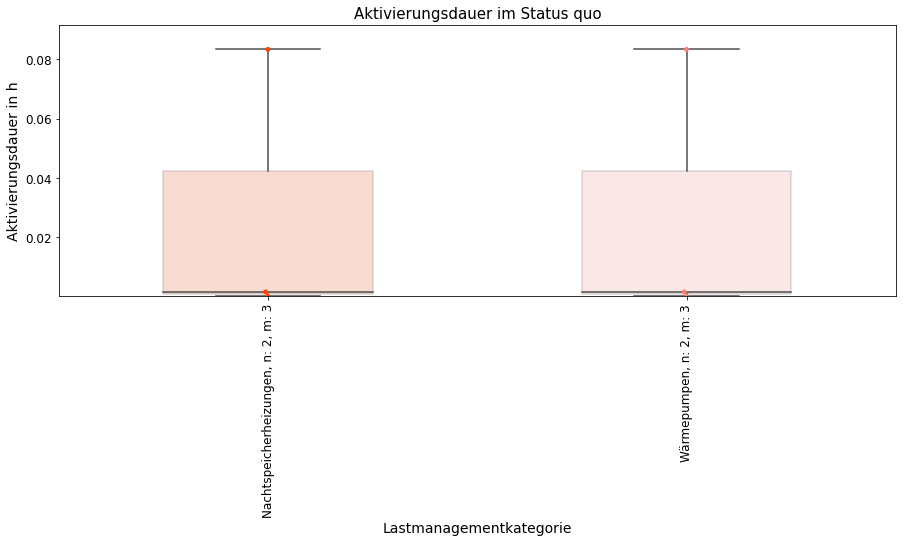

In [157]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Aktivierungsdauer",
    plot_ylabel="Aktivierungsdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### interference duration positive load shifting

In [158]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_hoho_stats",
    file_name_sources="interference_duration_pos_hoho_sources",
    filter_sector=filter_sector
)

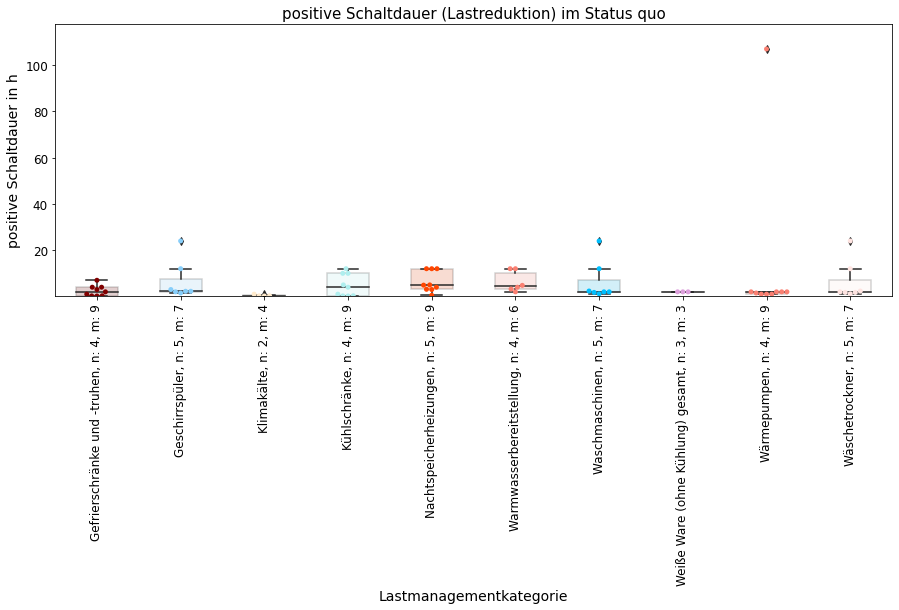

In [159]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastreduktion)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### interference duration positive load shedding

In [160]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_shed_hoho_stats",
    file_name_sources="interference_duration_pos_shed_hoho_sources",
    filter_sector=filter_sector
)

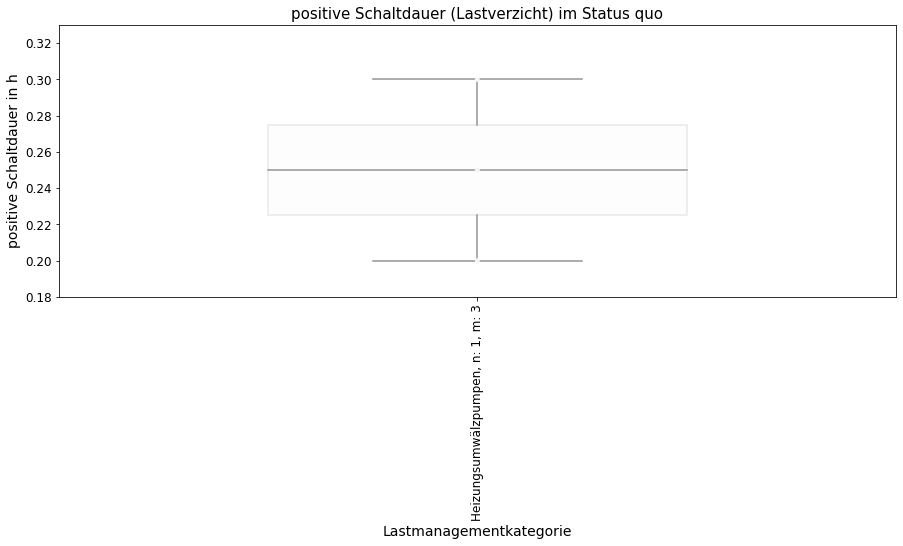

In [161]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastverzicht)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### interference duration negative

In [162]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="interference_duration_neg_hoho_stats",
    file_name_sources="interference_duration_neg_hoho_sources",
    filter_sector=filter_sector
)

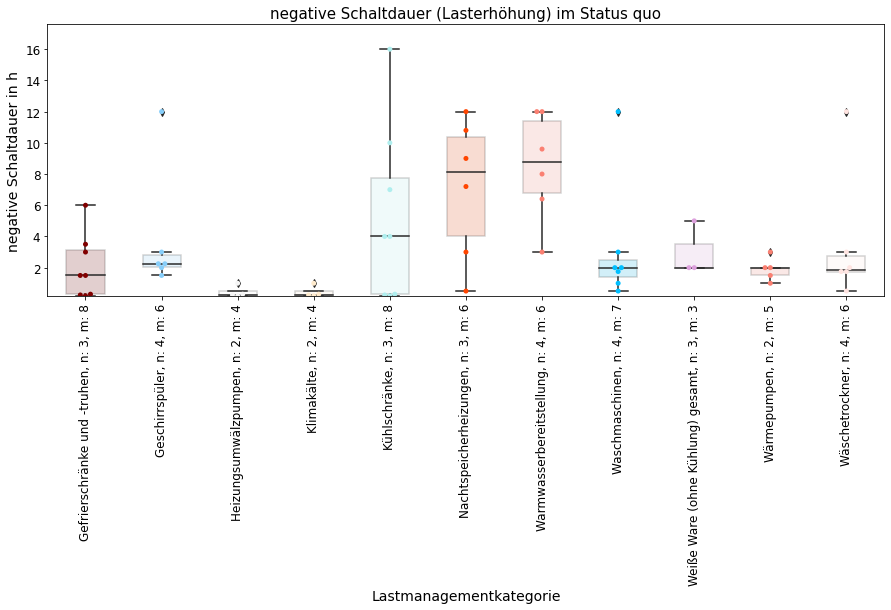

In [163]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="negative Schaltdauer (Lasterhöhung)",
    plot_ylabel="negative Schaltdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### shifting duration

In [164]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="shifting_duration_hoho_stats",
    file_name_sources="shifting_duration_hoho_sources",
    filter_sector=filter_sector
)

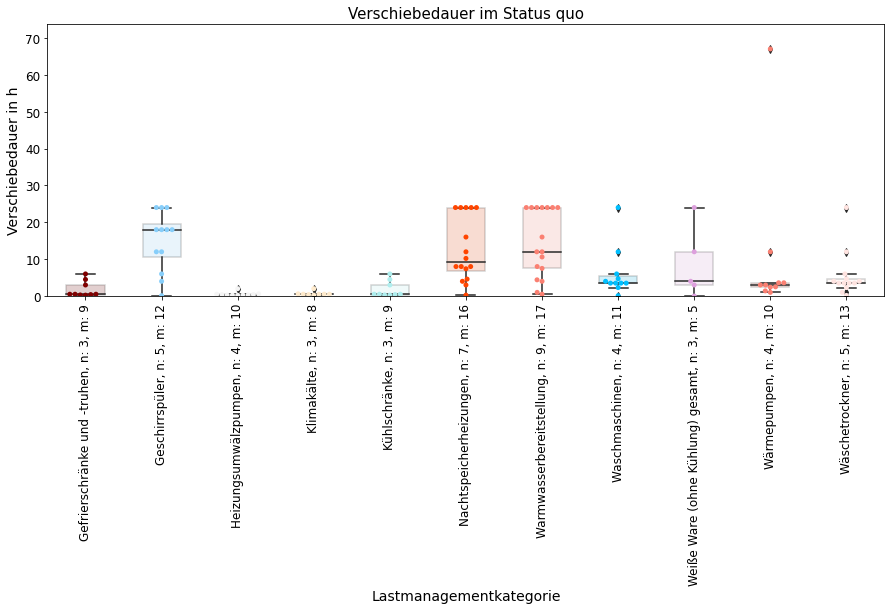

In [165]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Verschiebedauer",
    plot_ylabel="Verschiebedauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

### regeneration duration

In [166]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="regeneration_duration_hoho_stats",
    file_name_sources="regeneration_duration_hoho_sources",
    filter_sector=filter_sector
)

In [167]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Regenerationsdauer",
    plot_ylabel="Regenerationsdauer in h",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


### maximum activations per year load shifting

In [168]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_hoho_stats",
    file_name_sources="maximum_activations_year_hoho_sources",
    filter_sector=filter_sector
)

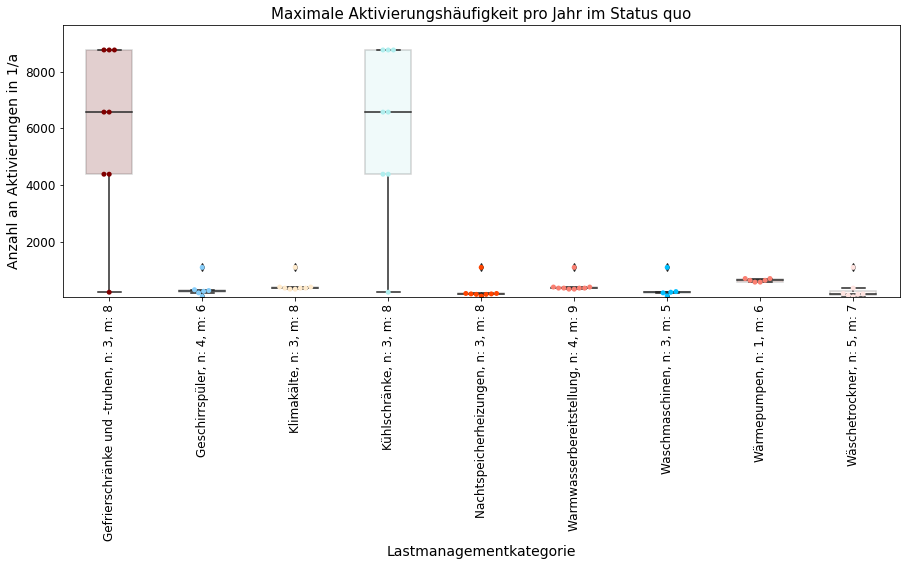

In [169]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors,
    filter_sector=filter_sector
)

### maximum activations per year load shedding

In [170]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_shed_hoho_stats",
    file_name_sources="maximum_activations_year_shed_hoho_sources",
    filter_sector=filter_sector
)

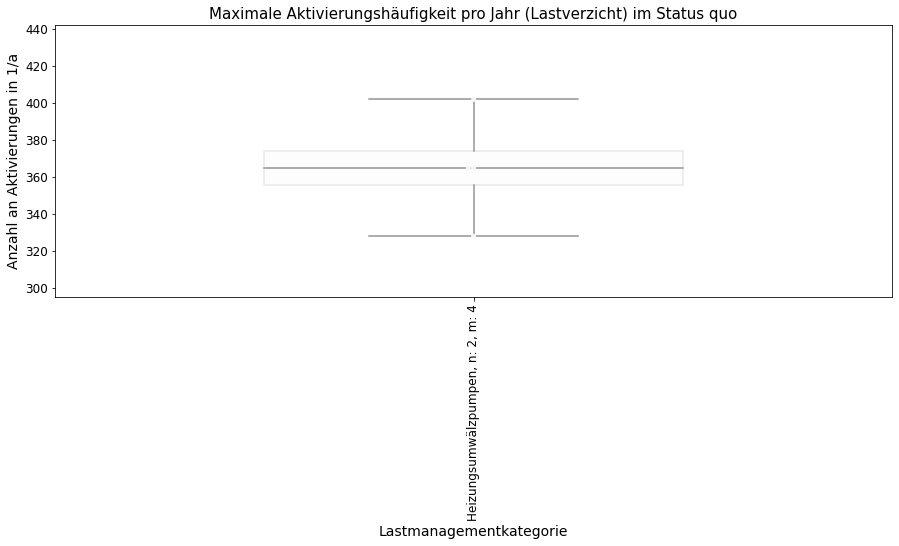

In [171]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr (Lastverzicht)",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors,
    filter_sector=filter_sector
)

# Cost-related parameters
In the following, all cost-related demand response parameters are evaluated. These comprise
* specific investments (in $€_{2018}/kW$),
* variable costs (in $€_{2018}/MWh$) as well as
* fixed costs (in $€_{2018}/kW$).

The evaluation is carried out per process / appliance for a given sector and year.

## Industry

### Specific investments

In [172]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="specific_investments_ind_stats",
    file_name_sources="specific_investments_ind_sources",
    filter_sector=filter_sector
)

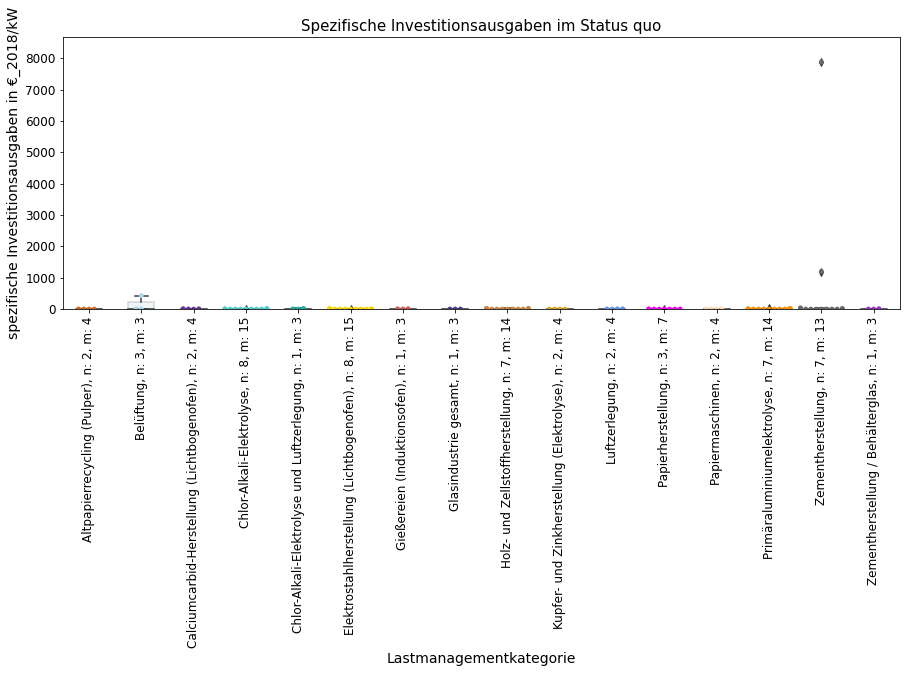

In [173]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Spezifische Investitionsausgaben",
    plot_ylabel="spezifische Investitionsausgaben in €_2018/kW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### variable costs load shifting

In [174]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="variable_costs_ind_stats",
    file_name_sources="variable_costs_ind_sources",
    filter_sector=filter_sector
)

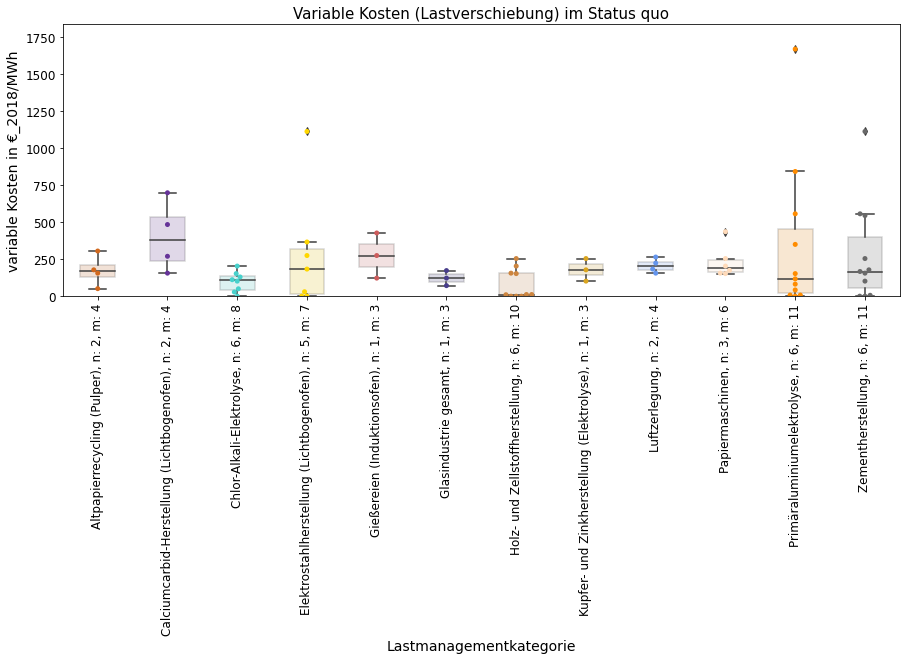

In [175]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverschiebung)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors,
    filter_sector=filter_sector
)

### variable costs load shedding

In [176]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="variable_costs_shed_ind_stats",
    file_name_sources="variable_costs_shed_ind_sources",
    filter_sector=filter_sector
)

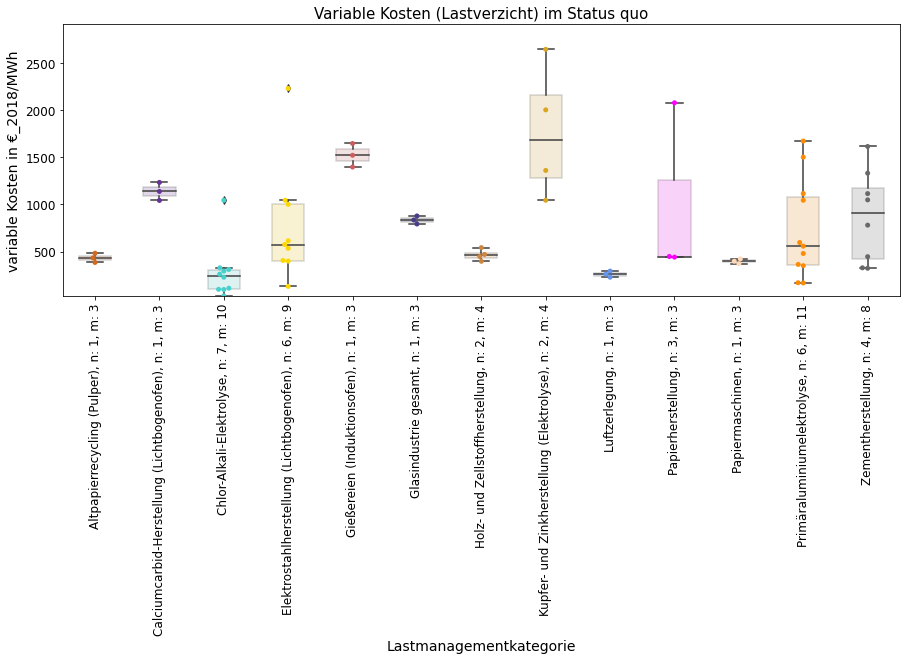

In [177]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverzicht)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors,
    filter_sector=filter_sector
)

### fixed costs

In [178]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="fixed_costs_ind_stats",
    file_name_sources="fixed_costs_ind_sources",
    filter_sector=filter_sector
)

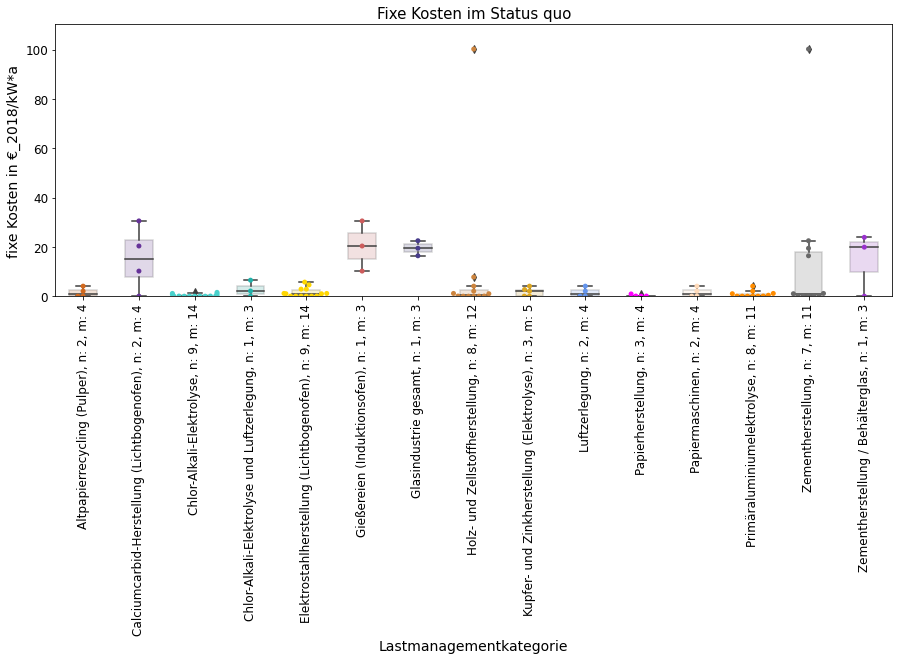

In [179]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Fixe Kosten",
    plot_ylabel="fixe Kosten in €_2018/kW*a",
    plot_colors=colors,
    filter_sector=filter_sector
)

## Trade, commerce and services

### Specific investments

In [180]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="specific_investments_tcs_stats",
    file_name_sources="specific_investments_tcs_sources",
    filter_sector=filter_sector
)

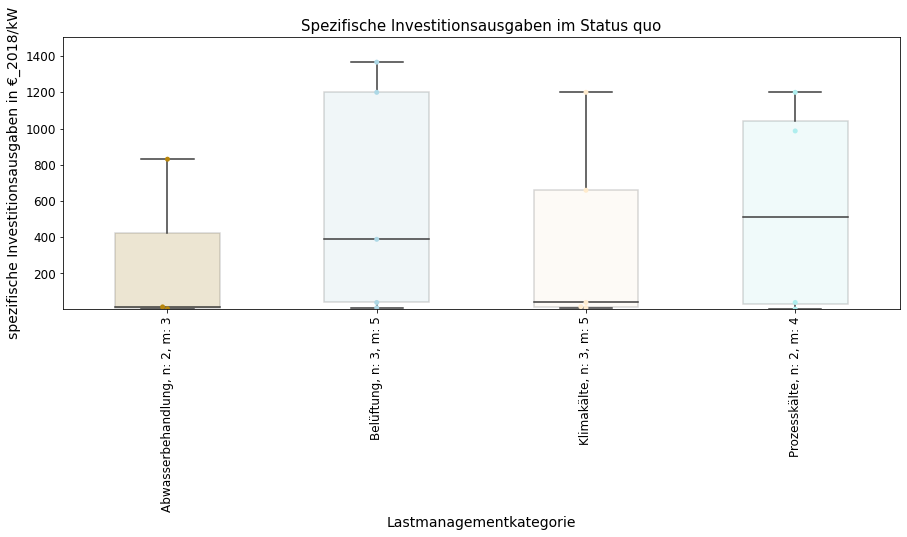

In [181]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Spezifische Investitionsausgaben",
    plot_ylabel="spezifische Investitionsausgaben in €_2018/kW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### variable costs load shifting

In [182]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="variable_costs_tcs_stats",
    file_name_sources="variable_costs_tcs_sources",
    filter_sector=filter_sector
)

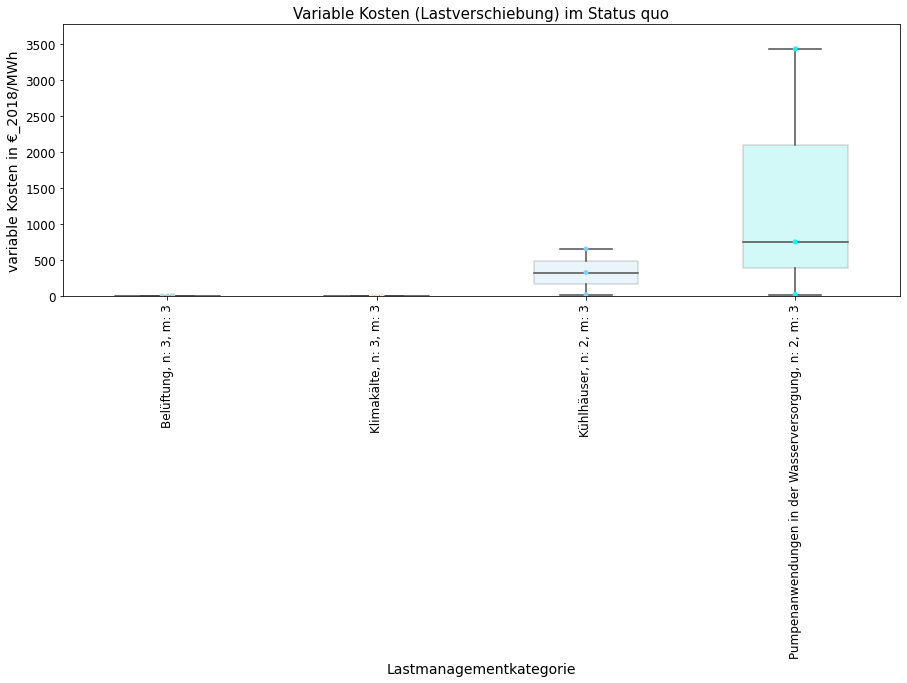

In [183]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverschiebung)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors,
    filter_sector=filter_sector
)

### variable costs load shedding

In [184]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="variable_costs_shed_tcs_stats",
    file_name_sources="variable_costs_shed_tcs_sources",
    filter_sector=filter_sector
)

In [185]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverzicht)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


### fixed costs

In [186]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="fixed_costs_tcs_stats",
    file_name_sources="fixed_costs_tcs_sources",
    filter_sector=filter_sector
)

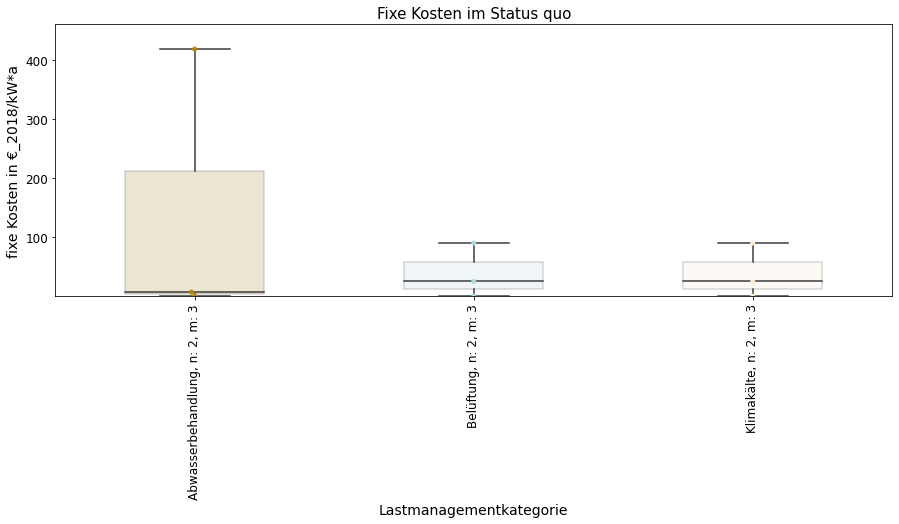

In [187]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Fixe Kosten",
    plot_ylabel="fixe Kosten in €_2018/kW*a",
    plot_colors=colors,
    filter_sector=filter_sector
)

## Households

### Specific investments

In [188]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="specific_investments_hoho_stats",
    file_name_sources="specific_investments_hoho_sources",
    filter_sector=filter_sector
)

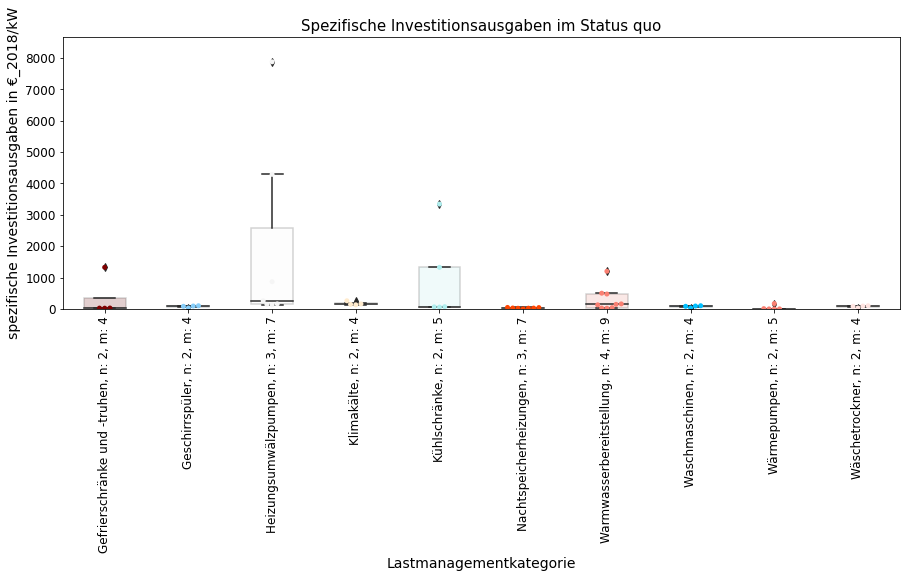

In [189]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Spezifische Investitionsausgaben",
    plot_ylabel="spezifische Investitionsausgaben in €_2018/kW",
    plot_colors=colors,
    filter_sector=filter_sector
)

### variable costs load shifting

In [190]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="variable_costs_hoho_stats",
    file_name_sources="variable_costs_hoho_sources",
    filter_sector=filter_sector
)

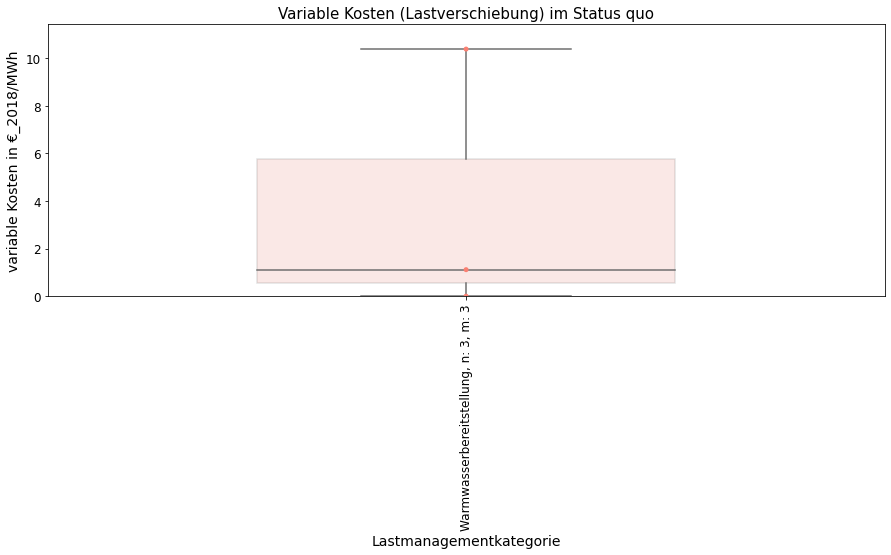

In [191]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverschiebung)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors,
    filter_sector=filter_sector
)

### variable costs load shedding

In [192]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="variable_costs_shed_hoho_stats",
    file_name_sources="variable_costs_shed_hoho_sources",
    filter_sector=filter_sector
)

In [193]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverzicht)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors,
    filter_sector=filter_sector
)

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:399: UserWarning: No numeric data to plot.
  warnings.warn("No numeric data to plot.", UserWarning)


### fixed costs

In [194]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="fixed_costs_hoho_stats",
    file_name_sources="fixed_costs_hoho_sources",
    filter_sector=filter_sector
)

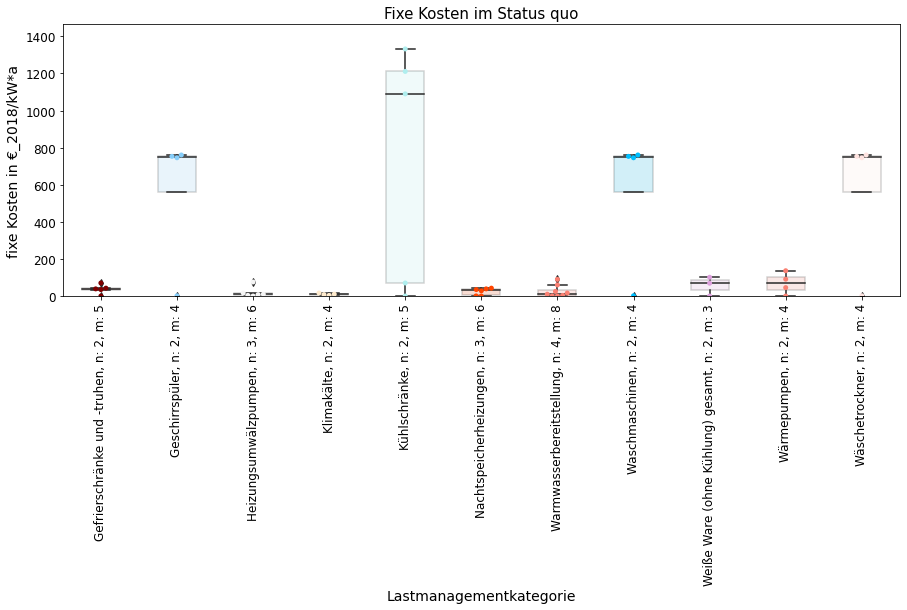

In [195]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Fixe Kosten",
    plot_ylabel="fixe Kosten in €_2018/kW*a",
    plot_colors=colors,
    filter_sector=filter_sector
)

# Potential outlook
In this section, an outlook for the future development of some Demand Response parameters up to (at most) 2050 is given.
Future development for the following parameters is assessed
* Capacity-related parameters: positive load shift potential, negative load shift potential
* Cost-related parameters: specific investments, variable costs and fixed costs

Time-related parameters are assumed to remain the same. Changes in processes are out of scope resp. depicted in the changes of the potentials themselves.

## Industry

### Select some processes for further analysis
There are two ways to determine, which processes resp. appliances shall be further evaluated:
* one rather systematic one choosing those with the highest potential (in the status quo resp. in 2050) and
* a self-defined selection of processes which is influenced by the literature itself (and a potential personal bias).
It can be chosen between the two by using the control parameter `use_nlargest_cols`.

Method and criterions used for selection when using the columns with the highest potentials:
* Select those with highest demand response potential in the status quo.
* Select those with highest demand response potential in the 2050.
* Combine the two.

In [196]:
if not use_nlargest_cols:
    industry_cols = ["Chlor-Alkali-Elektrolyse", 
                     "Elektrostahlherstellung (Lichtbogenofen)", 
                     "Primäraluminiumelektrolyse", 
                     "Holz- und Zellstoffherstellung"]
else:
    industry_cols = extract_nlargest(
        grouped, 
        "ind", years_dict, 
        drop_data_lack=True, metric="50%", n=5,
        filter_sector=filter_sector
    )

### Positive load shift potential

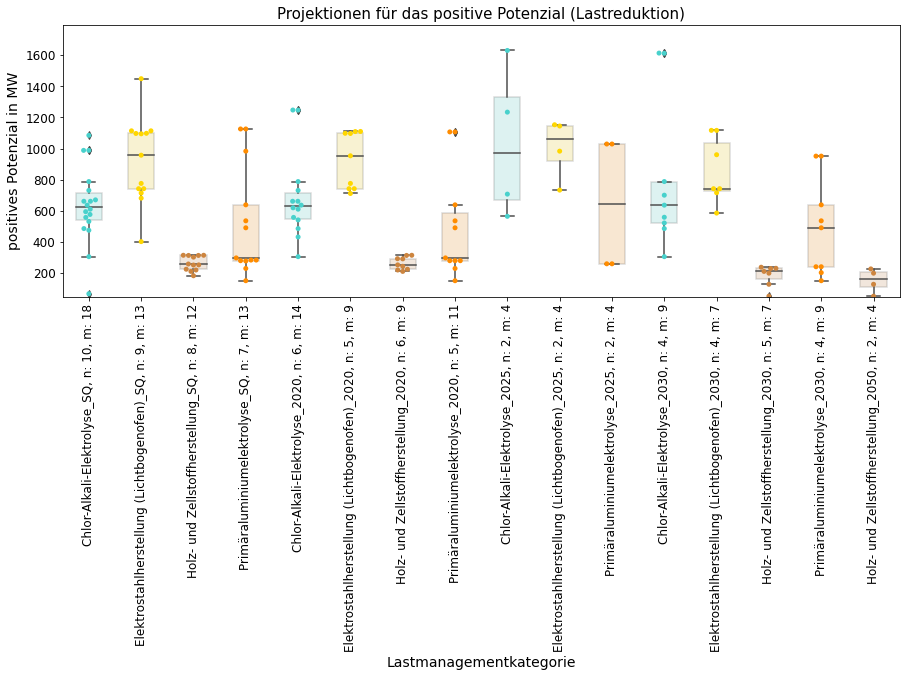

In [197]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    ["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    "ind",
    years_dict,
    "Projektionen für das positive Potenzial (Lastreduktion)",
    "positives Potenzial in MW",
    plot_colors=colors,
    processes=industry_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_potential_pos_overall_ind.txt",
    filter_sector=filter_sector
)

### Negative load shift potential

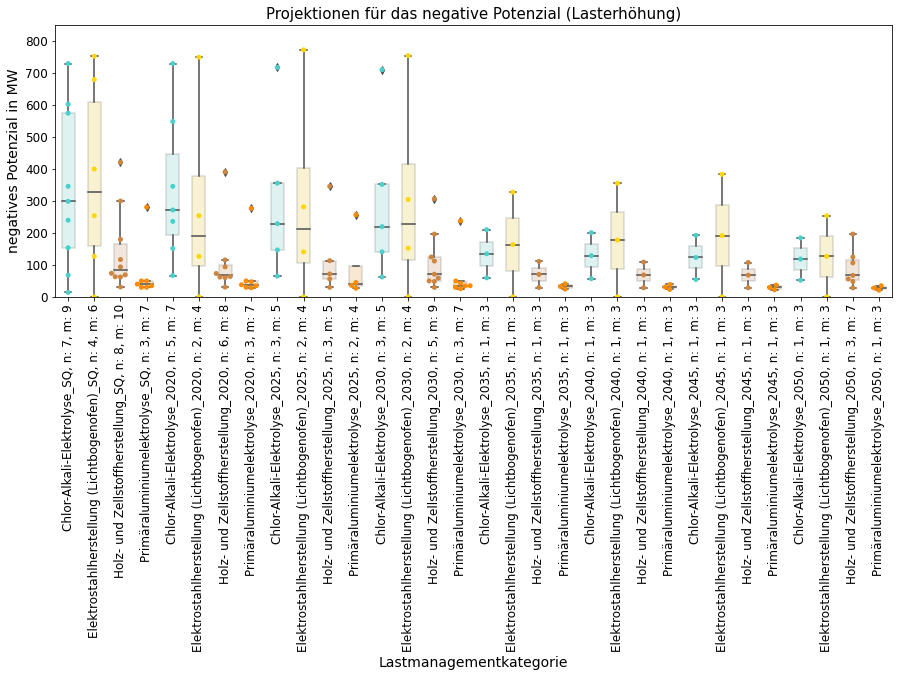

In [198]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    ["Potenzial negativ Mittel", "Potenzial negativ min", "Potenzial negativ max"],
    "ind",
    years_dict,
    "Projektionen für das negative Potenzial (Lasterhöhung)",
    "negatives Potenzial in MW",
    plot_colors=colors,
    processes=industry_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_potential_neg_overall_ind.txt",
    filter_sector=filter_sector
)

### Specific investments

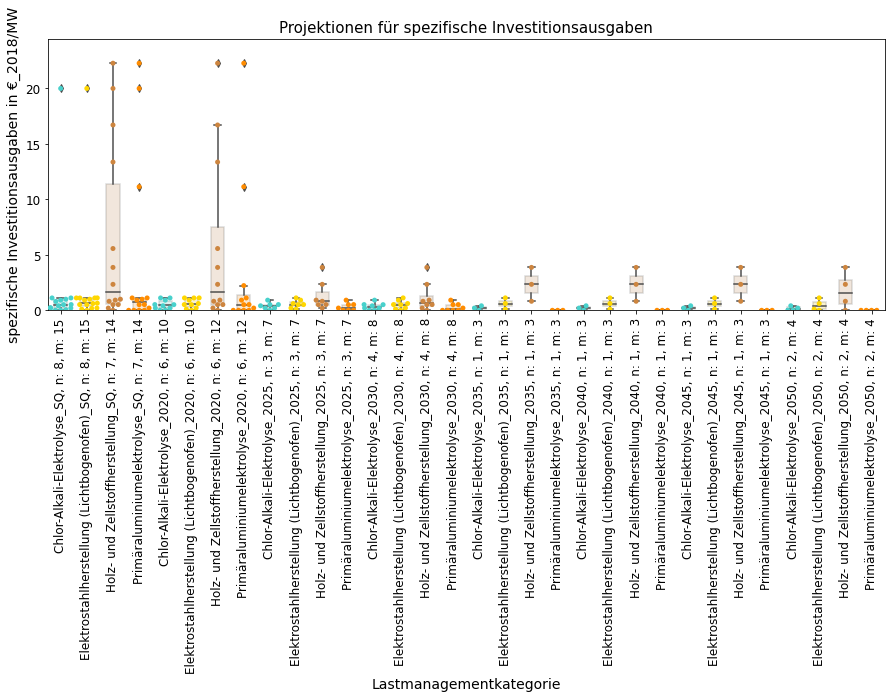

In [199]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    "Investitionsausgaben",
    "ind",
    years_dict,
    "Projektionen für spezifische Investitionsausgaben",
    "spezifische Investitionsausgaben in €_2018/MW",
    plot_colors=colors,
    processes=industry_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_specific_investments_ind.txt",
    filter_sector=filter_sector
)

### Variable costs

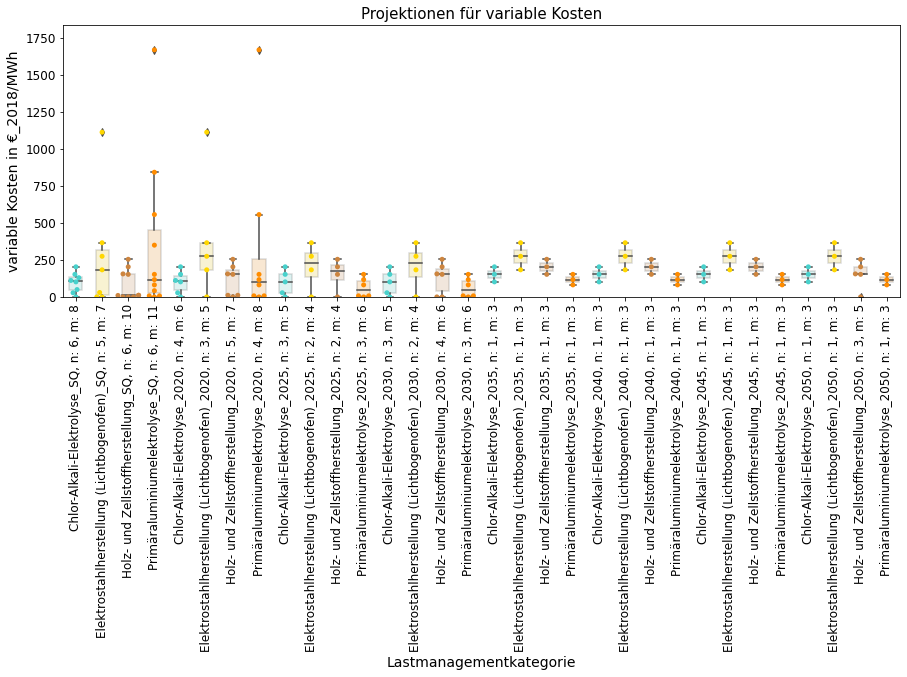

In [200]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    "variable Kosten",
    "ind",
    years_dict,
    "Projektionen für variable Kosten",
    "variable Kosten in €_2018/MWh",
    plot_colors=colors,
    processes=industry_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_variable_costs_ind.txt",
    filter_sector=filter_sector
)

### Fixed costs

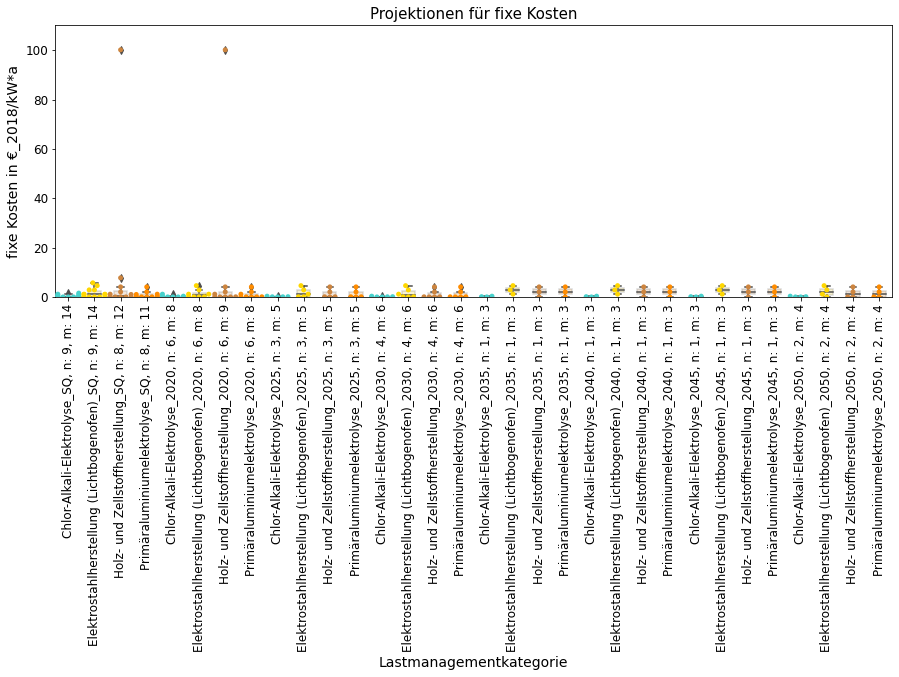

In [201]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    "fixe Kosten",
    "ind",
    years_dict,
    "Projektionen für fixe Kosten",
    "fixe Kosten in €_2018/kW*a",
    plot_colors=colors,
    processes=industry_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_fixed_costs_ind.txt",
    filter_sector=filter_sector
)

## Trade, commerce and services

### Select some processes for further analysis

In [202]:
if not use_nlargest_cols:
    tcs_cols = ["Prozesskälte", "Belüftung", "Klimakälte", 
                "Pumpenanwendungen in der Wasserversorgung"]
else:
    tcs_cols = extract_nlargest(
        grouped, "tcs", years_dict, drop_data_lack=True, metric="50%", n=5,
        filter_sector=filter_sector
    )

### Positive load shift potential

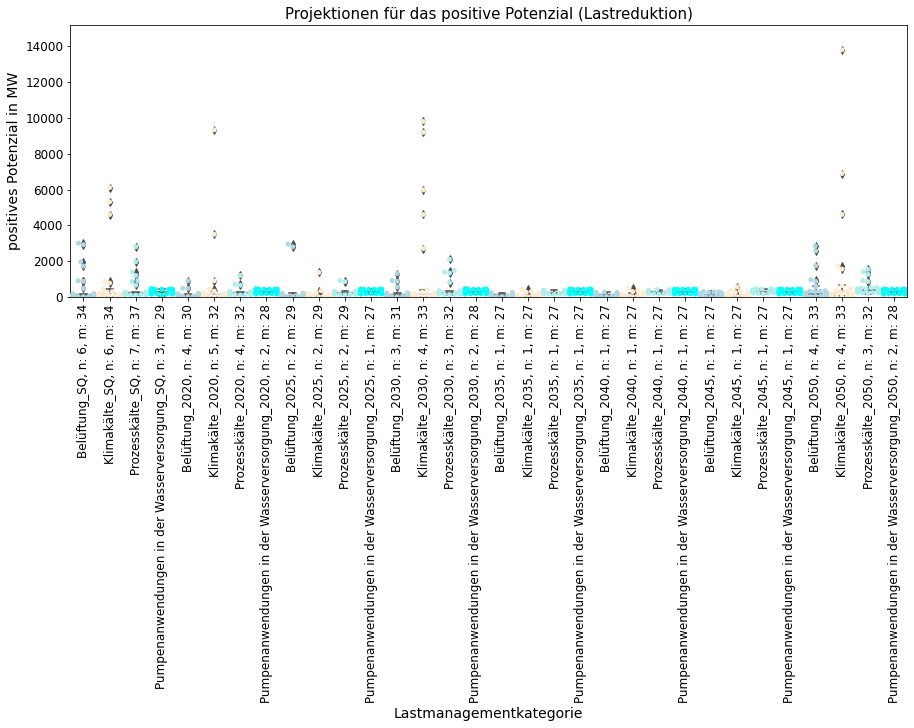

In [203]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    ["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    "tcs",
    years_dict,
    "Projektionen für das positive Potenzial (Lastreduktion)",
    "positives Potenzial in MW",
    plot_colors=colors,
    processes=tcs_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_potential_pos_overall_tcs.txt",
    filter_sector=filter_sector
)

### Negative load shift potential

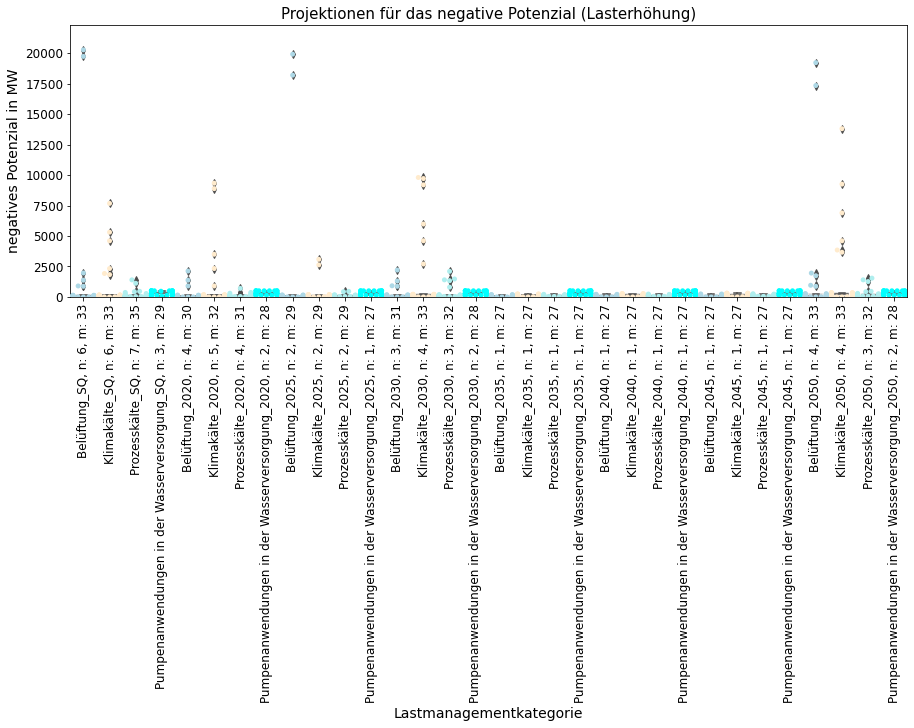

In [204]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    ["Potenzial negativ Mittel", "Potenzial negativ min", "Potenzial negativ max"],
    "tcs",
    years_dict,
    "Projektionen für das negative Potenzial (Lasterhöhung)",
    "negatives Potenzial in MW",
    plot_colors=colors,
    processes=tcs_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_potential_neg_overall_tcs.txt",
    filter_sector=filter_sector
)

### Specific investments

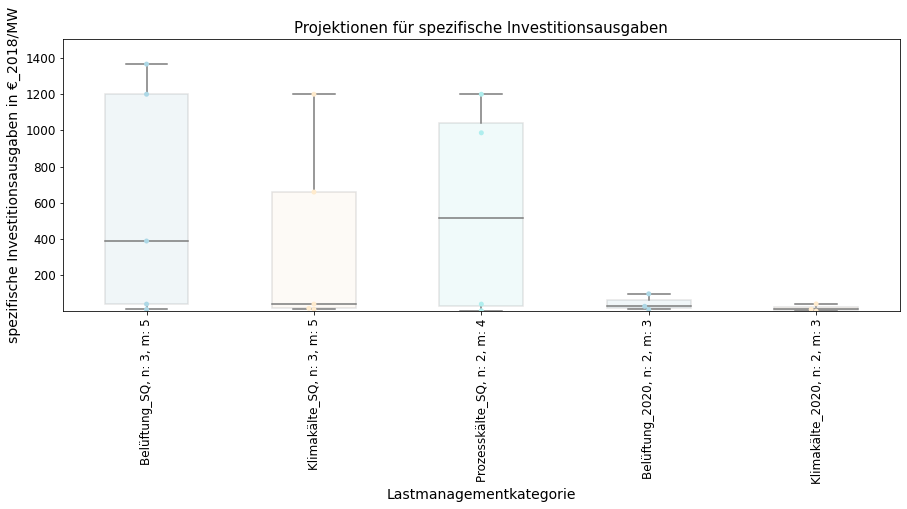

In [205]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    "Investitionsausgaben",
    "tcs",
    years_dict,
    "Projektionen für spezifische Investitionsausgaben",
    "spezifische Investitionsausgaben in €_2018/MW",
    plot_colors=colors,
    processes=tcs_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_specific_investments_tcs.txt",
    filter_sector=filter_sector
)

### Variable costs

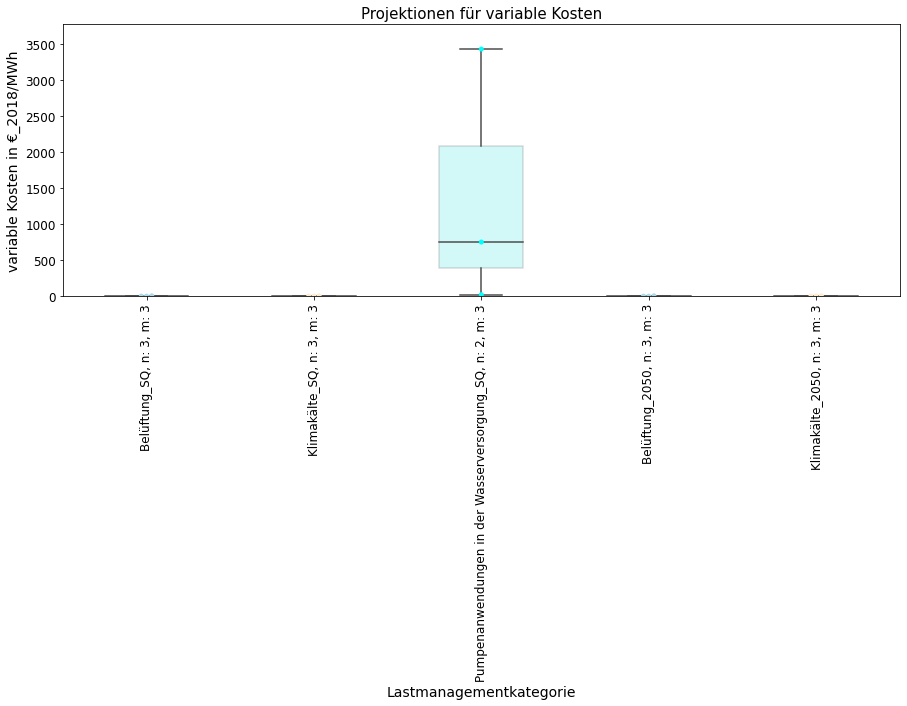

In [206]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    "variable Kosten",
    "tcs",
    years_dict,
    "Projektionen für variable Kosten",
    "variable Kosten in €_2018/MWh",
    plot_colors=colors,
    processes=tcs_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_variable_costs_tcs.txt",
    filter_sector=filter_sector
)

### Fixed costs

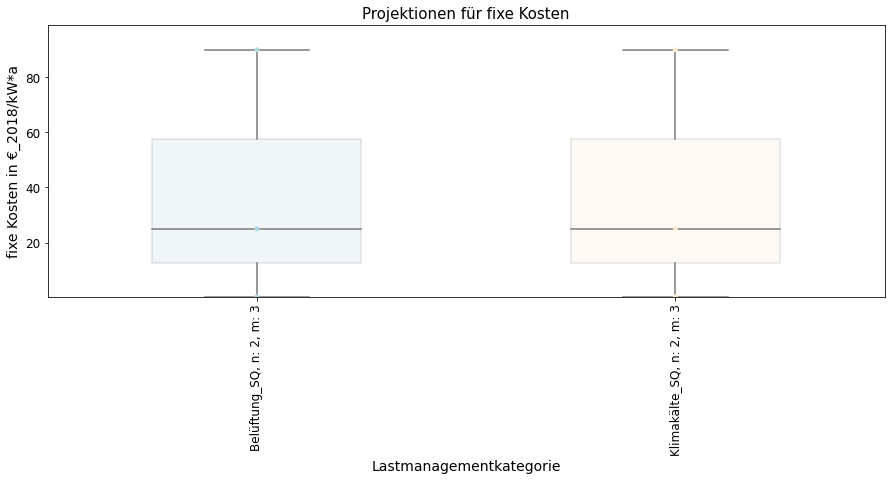

In [207]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    "fixe Kosten",
    "tcs",
    years_dict,
    "Projektionen für fixe Kosten",
    "fixe Kosten in €_2018/kW*a",
    plot_colors=colors,
    processes=tcs_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_fixed_costs_tcs.txt",
    filter_sector=filter_sector
)

## Households

### Select some processes for further analysis

In [208]:
if not use_nlargest_cols:
    hoho_cols = ["Wärmepumpen", 
                 "Nachtspeicherheizungen", 
                 "Klimakälte", 
                 "Kühlschränke"]
else:
    hoho_cols = extract_nlargest(
        grouped, "hoho", years_dict, drop_data_lack=True, metric="50%", n=5,
        filter_sector=filter_sector
    )

### Positive load shift potential

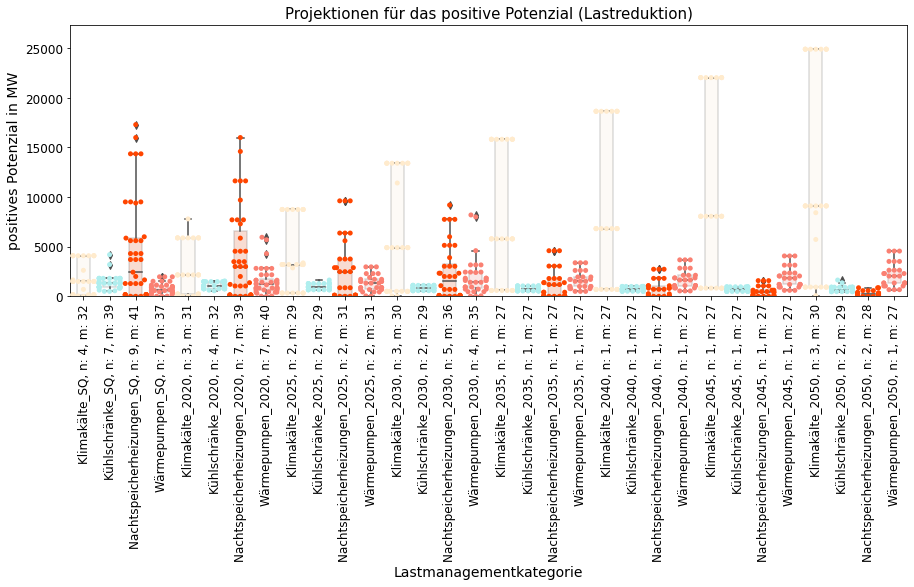

In [209]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    ["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    "hoho",
    years_dict,
    "Projektionen für das positive Potenzial (Lastreduktion)",
    "positives Potenzial in MW",
    plot_colors=colors,
    processes=hoho_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_potential_pos_overall_hoho.txt",
    filter_sector=filter_sector
)

### Negative load shift potential

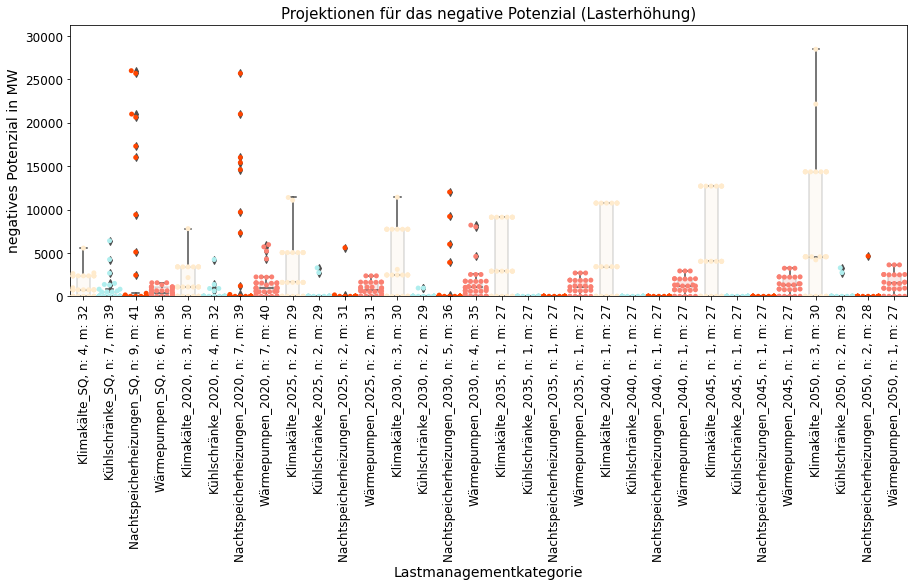

In [210]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    ["Potenzial negativ Mittel", "Potenzial negativ min", "Potenzial negativ max"],
    "hoho",
    years_dict,
    "Projektionen für das negative Potenzial (Lasterhöhung)",
    "negatives Potenzial in MW",
    plot_colors=colors,
    processes=hoho_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_potential_neg_overall_hoho.txt",
    filter_sector=filter_sector
)

### Specific investments

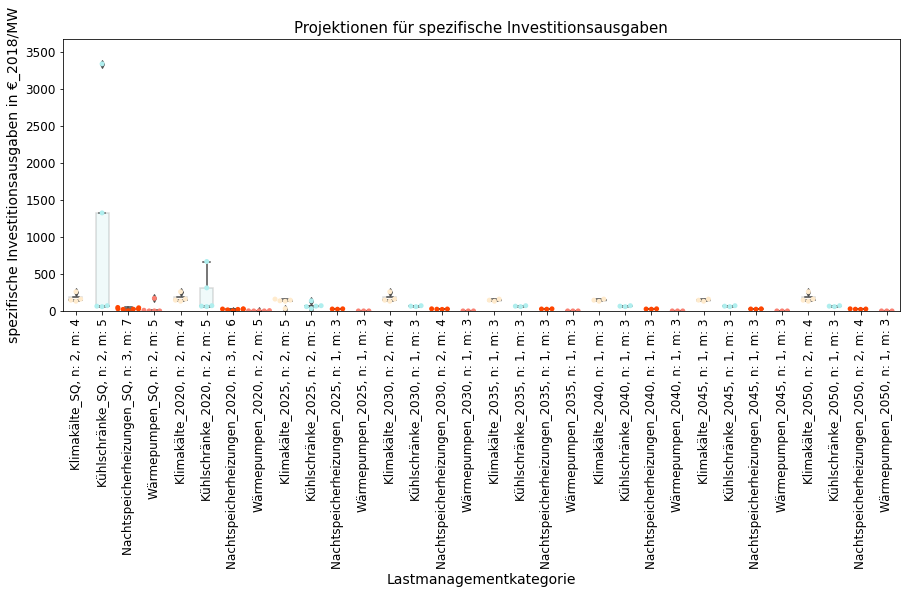

In [211]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    "Investitionsausgaben",
    "hoho",
    years_dict,
    "Projektionen für spezifische Investitionsausgaben",
    "spezifische Investitionsausgaben in €_2018/MW",
    plot_colors=colors,
    processes=hoho_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_specific_investments_hoho.txt",
    filter_sector=filter_sector
)

### Variable costs

C:\Users\koch_j0\DR_mod\DR_Potentials\drpotentials\evaluation_funcs.py:473: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  _ = plt.ylim(ylim)


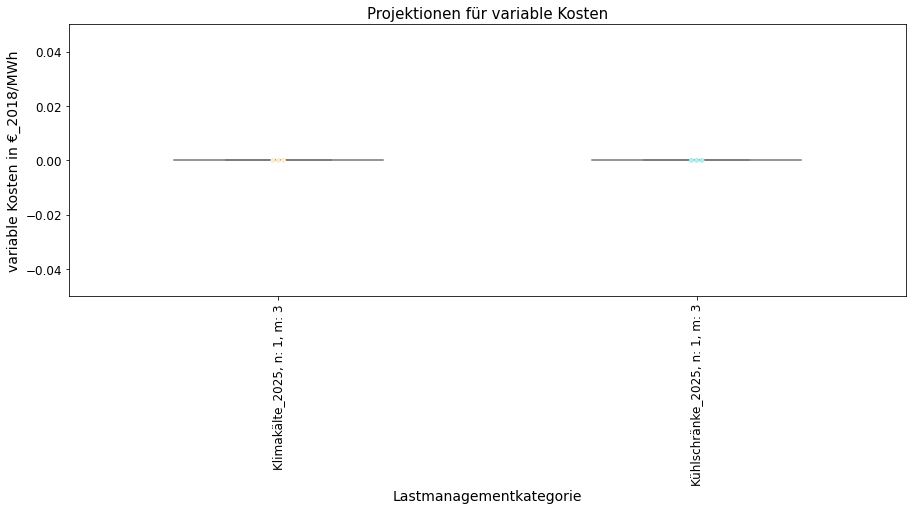

In [212]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    "variable Kosten",
    "hoho",
    years_dict,
    "Projektionen für variable Kosten",
    "variable Kosten in €_2018/MWh",
    plot_colors=colors,
    processes=hoho_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_variable_costs_hoho.txt",
    filter_sector=filter_sector
)

### Fixed costs

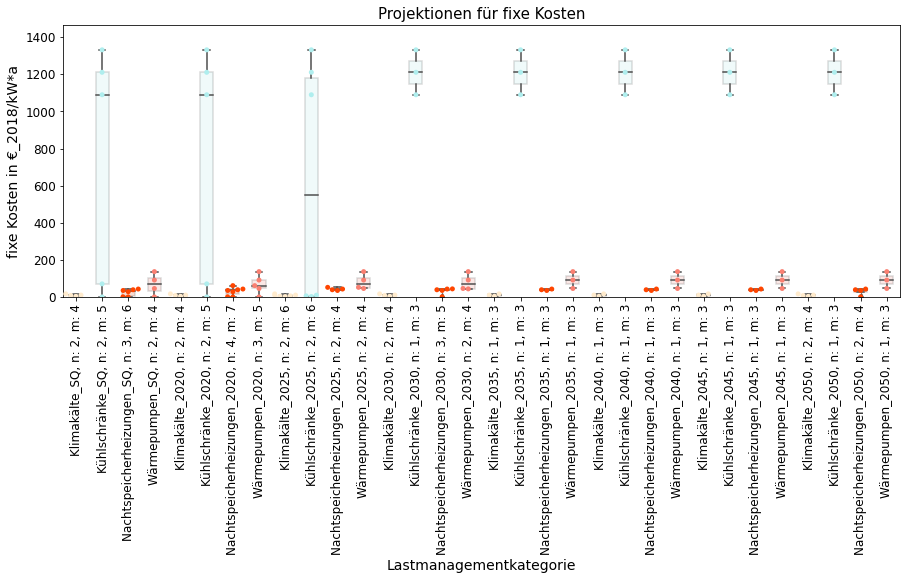

In [213]:
extract_projection_for_all_years(
    grouped, 
    swapped_cols_dict, 
    "fixe Kosten",
    "hoho",
    years_dict,
    "Projektionen für fixe Kosten",
    "fixe Kosten in €_2018/kW*a",
    plot_colors=colors,
    processes=hoho_cols,
    drop_data_lack=True,
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources_projection_fixed_costs_hoho.txt",
    filter_sector=filter_sector
)